<a href="https://colab.research.google.com/github/seymaerdogan0/breast-tumor-classification/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# ZIP dosyasını çıkar
zip_path = '/content/drive/MyDrive/BreaKHis_v1 (1).zip'
extract_path = '/content/BreaKHis_v1_clean'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Yeni ZIP başarıyla çıkarıldı.")


Yeni ZIP başarıyla çıkarıldı.


In [ ]:

import os

# Her şey doğru çıkmış mı, ilk klasörleri listele
for folder in os.listdir(extract_path):
    print(folder)


BreaKHis_v1


In [ ]:
import os

for root, dirs, files in os.walk('/content/BreaKHis_v1_clean/BreaKHis_v1'):
    print("Klasör:", root)
    for d in dirs:
        print("  Alt klasör:", d)
    for f in files:
        print("  Dosya:", f)


Klasör: /content/BreaKHis_v1_clean/BreaKHis_v1
  Alt klasör: histology_slides
Klasör: /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides
  Alt klasör: breast
Klasör: /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast
  Alt klasör: malignant
  Alt klasör: benign
  Dosya: README.txt
  Dosya: count_files.sh
Klasör: /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast/malignant
  Alt klasör: SOB
  Dosya: ductal_carcinoma.stat.txt
  Dosya: process_db_stat.py
  Dosya: ductal_carcinoma.stat.txt.SOB
  Dosya: lobular_carcinoma.stat.txt
  Dosya: papillary_carcinoma.stat.txt
  Dosya: mucinous_carcinoma.stat.txt
Klasör: /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast/malignant/SOB
  Alt klasör: mucinous_carcinoma
  Alt klasör: lobular_carcinoma
  Alt klasör: papillary_carcinoma
  Alt klasör: ductal_carcinoma
Klasör: /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma
  Alt klasör: SOB_M_MC_14-18842
  Alt klasör: 

In [ ]:
!ls /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast/


benign	count_files.sh	malignant  README.txt


✅ Tüm klasörlerde görüntü bulundu.


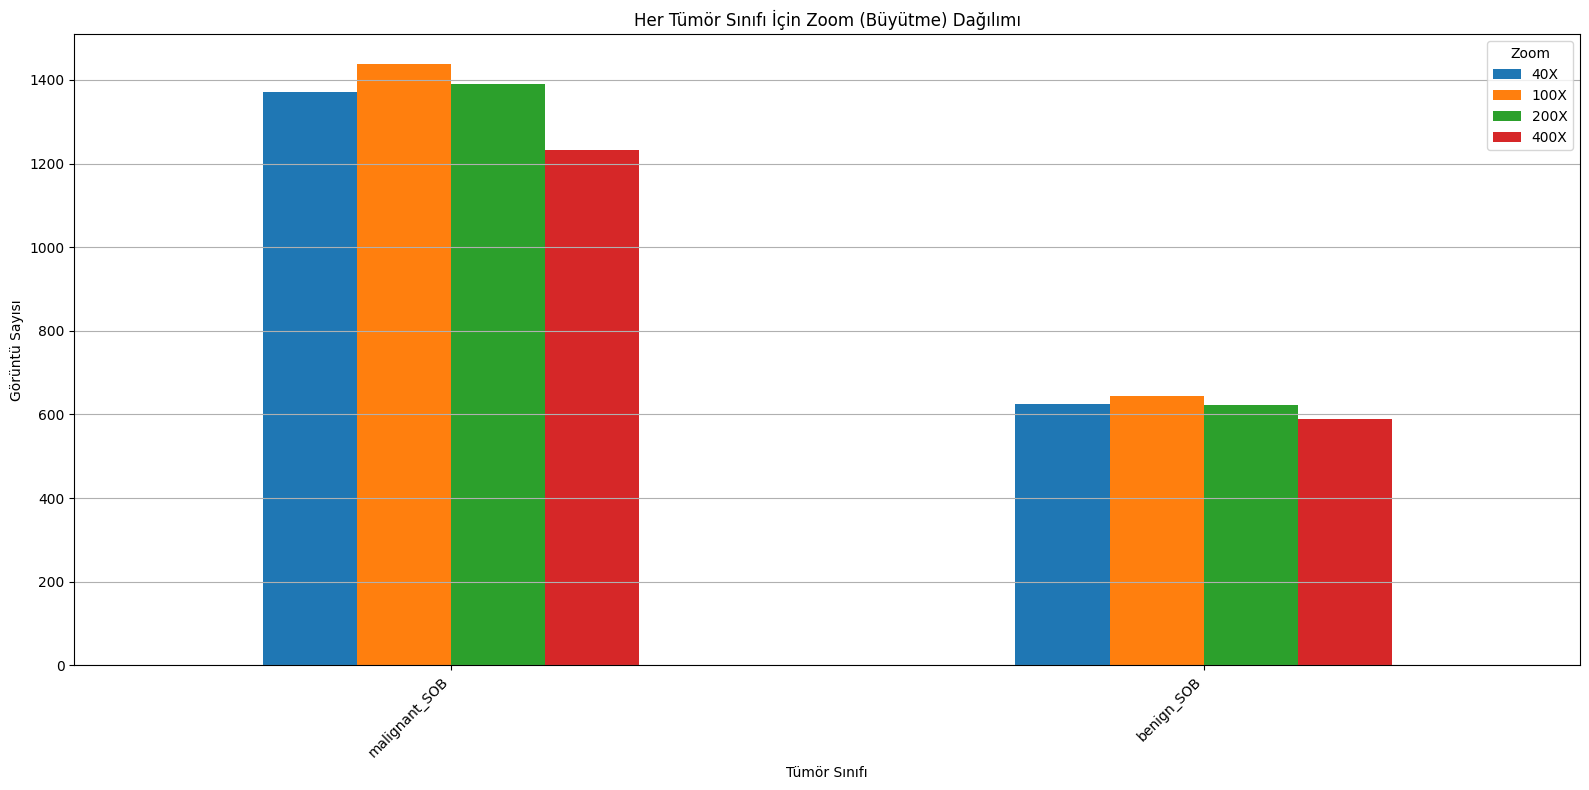

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# 🔧 Ana dizin
root_dir = root_dir = "/content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast"


# 📦 Zoom ve görsel sayıları için dict
zoom_counts = defaultdict(lambda: defaultdict(int))
empty_dirs = []

# 🔁 Tüm klasörleri tara
for biopsy_type in os.listdir(root_dir):  # benign, malignant
    biopsy_path = os.path.join(root_dir, biopsy_type)
    if not os.path.isdir(biopsy_path):
        continue

    for tumor_type in os.listdir(biopsy_path):  # adenosis, ductal_carcinoma vs.
        tumor_path = os.path.join(biopsy_path, tumor_type)
        if not os.path.isdir(tumor_path):
            continue

        tumor_label = f"{biopsy_type}_{tumor_type}"
        found_image = False

        for root_, dirs, files in os.walk(tumor_path):  # Tüm alt klasörleri tara
            zoom_level = os.path.basename(root_)  # 40X, 100X gibi
            num_images = len([f for f in files if f.lower().endswith(".png")])
            if num_images > 0:
                found_image = True
                zoom_counts[tumor_label][zoom_level] += num_images

        if not found_image:
            empty_dirs.append(tumor_path)

# 🧾 Boş klasörleri yazdır
if empty_dirs:
    print("❌ Boş klasör(ler) bulundu:")
    for d in empty_dirs:
        print(f"- {d}")
else:
    print("✅ Tüm klasörlerde görüntü bulundu.")

# 📊 DataFrame'e çevir
df = pd.DataFrame(zoom_counts).T.fillna(0).astype(int)

# 🔤 Zoom sırasını belirle
zoom_order = sorted([col for col in df.columns if col.endswith('X')], key=lambda x: int(x.replace('X','')))
df = df[zoom_order]  # varsa sıralı göster

# 📈 Grafik çizimi
df.plot(kind='bar', figsize=(16, 8))
plt.title("Her Tümör Sınıfı İçin Zoom (Büyütme) Dağılımı")
plt.xlabel("Tümör Sınıfı")
plt.ylabel("Görüntü Sayısı")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Zoom")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


#### Veri setinde büyütme (zoom) dağılımı

çubuk grafik, **malignant_SOB** ve **benign_SOB** alt klasörlerinde bulunan tüm görüntülerin dört farklı büyütme düzeyine (40×, 100×, 200×, 400×) göre dağılımını göstermektedir

bunu zoomlara göre ayırsam ve augmente etsem mi diye baktım ama her snıfta her zoom yok bu  nedenle yapazoomlara özel augmentasyon yapmak istemedim. sınıflara göre yapmak daha mantıklıgeldi



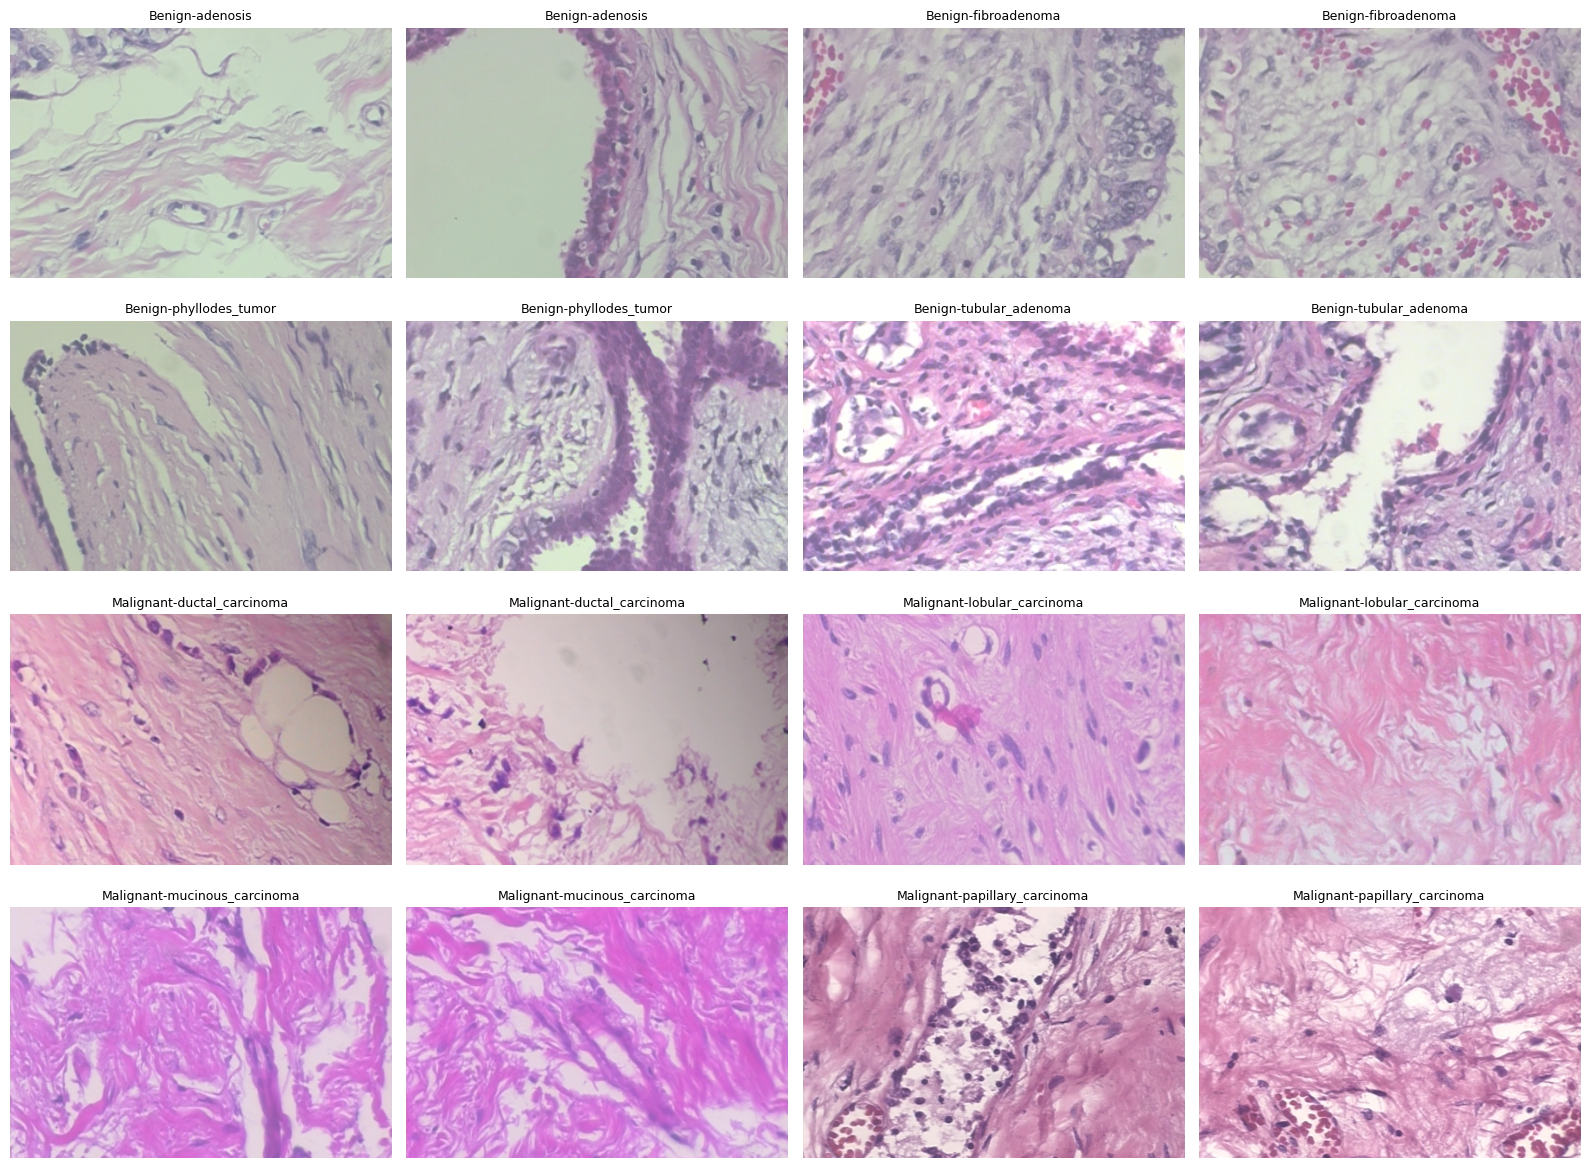

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

base_path = '/content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast'


tumor_types = {
    'Benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'Malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

plt.figure(figsize=(16, 12))
count = 1

for label, subtypes in tumor_types.items():
    for subtype in subtypes:
        subtype_path = os.path.join(base_path, label.lower(), 'SOB', subtype)

        found = False
        for root, dirs, files in os.walk(subtype_path):
            image_files = [f for f in files if f.endswith('.png')]
            if len(image_files) >= 2:
                selected = random.sample(image_files, 2)
                for img_file in selected:
                    if count > 16:  # 4x4 grid
                        break
                    img_path = os.path.join(root, img_file)
                    img = image.load_img(img_path)
                    plt.subplot(4, 4, count)
                    plt.imshow(img)
                    plt.title(f"{label}-{subtype}", fontsize=9)
                    plt.axis('off')
                    count += 1
                found = True
            if found:
                break
        if count > 16:
            break

plt.tight_layout()
plt.show()


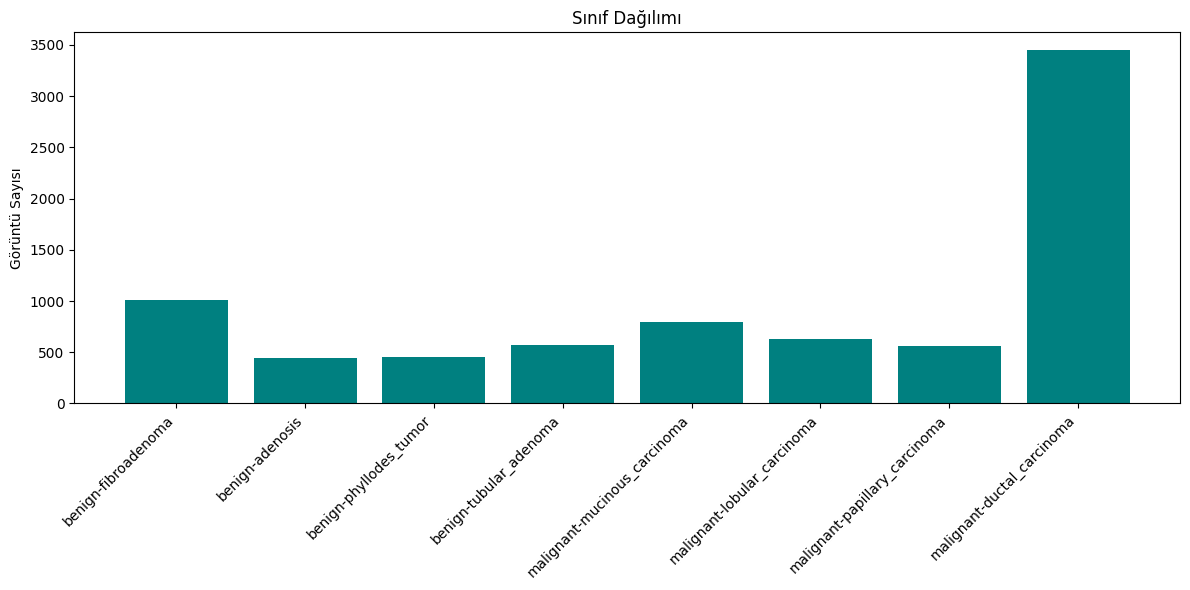

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

root_dir = '/content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast'

class_counts = defaultdict(int)

for label in ['benign', 'malignant']:
    class_dir = os.path.join(root_dir, label, 'SOB')
    for subtype in os.listdir(class_dir):
        subtype_dir = os.path.join(class_dir, subtype)
        for root, dirs, files in os.walk(subtype_dir):
            image_files = [f for f in files if f.endswith('.png')]
            class_counts[f"{label}-{subtype}"] += len(image_files)

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Görüntü Sayısı")
plt.title("Sınıf Dağılımı")
plt.tight_layout()
plt.show()


#### Alt-tip bazında örnek sayıları

* **malignant_ductal_carcinoma** verinin %40’ından fazlasını oluştururken, **benign_adenosis** ve **benign_fibroadenoma** gibi sınıflar çok daha az temsil edilmektedir.  
* Böyle bir **sınıf dengesizliği**, eğitilen modelin baskın sınıfa yönelmesine sebep olabilir.  

# ***bu nedenle önce sınıfı bu dengelere göre bölüp sonra az olan verileri augmente edeceğim***


# burdan önce tümör sınıfına göre ayırmamıştım o yüzdenn sınıfa göre  az olanları augmente edemedim. bu nedenle buna uygun bir veri ayrımı yapacağım

In [ ]:
import os, shutil, random
from sklearn.model_selection import train_test_split

src_root = '/content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast'
dst_root = '/content/BreaKHis_v1_clean/stratified_dataset'
split = (0.7, 0.15, 0.15)

filepaths, labels = [], []

for root, _, files in os.walk(src_root):
    for f in files:
        if not f.lower().endswith('.png'):
            continue
        zoom_dir   = root                       # …/40X
        case_dir   = os.path.dirname(zoom_dir)  # …/SOB_B_A_…
        subtype_dir= os.path.dirname(case_dir)  # …/adenosis   <-- İSTENEN **etiket**
        label      = os.path.basename(subtype_dir)
        filepaths.append(os.path.join(root, f))
        labels.append(label)

print(f"Toplam {len(filepaths)} görsel, {len(set(labels))} alt tip.")

X_tmp, X_test, y_tmp, y_test = train_test_split(
    filepaths, labels, test_size=split[2], stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=split[1]/(split[0]+split[1]),
    stratify=y_tmp, random_state=42)

def copy_group(files, labels, group):
    for fp, lab in zip(files, labels):
        dst_dir = os.path.join(dst_root, group, lab)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(fp, os.path.join(dst_dir, os.path.basename(fp)))

copy_group(X_train, y_train, 'train')
copy_group(X_val,   y_val,   'val')
copy_group(X_test,  y_test,  'test')

print("✅ Yeni split tamam.")


Toplam 7909 görsel, 8 alt tip.
✅ Yeni split tamam.


# burada veriyi spliit ettim. split ederken sınıf adlarına göre etiketlettirdim çünkü ona göre az olan sınıfları augmente edicem


In [ ]:
ls /content/BreaKHis_v1_clean/stratified_dataset


test/  train/  val/


In [ ]:
from collections import Counter

def show_dist(y, name):
    cnt   = Counter(y)
    total = sum(cnt.values())
    print(f"\n{name} (n={total})")
    for lab, c in cnt.items():
        print(f"{lab:<30}: {c:4d}  ({c/total:.2%})")

show_dist(y_train, 'Train')
show_dist(y_val,   'Val')
show_dist(y_test,  'Test')



Train (n=5535)
ductal_carcinoma              : 2415  (43.63%)
adenosis                      :  310  (5.60%)
phyllodes_tumor               :  317  (5.73%)
papillary_carcinoma           :  392  (7.08%)
tubular_adenoma               :  399  (7.21%)
fibroadenoma                  :  710  (12.83%)
mucinous_carcinoma            :  554  (10.01%)
lobular_carcinoma             :  438  (7.91%)

Val (n=1187)
ductal_carcinoma              :  518  (43.64%)
mucinous_carcinoma            :  119  (10.03%)
tubular_adenoma               :   85  (7.16%)
fibroadenoma                  :  152  (12.81%)
phyllodes_tumor               :   68  (5.73%)
adenosis                      :   67  (5.64%)
papillary_carcinoma           :   84  (7.08%)
lobular_carcinoma             :   94  (7.92%)

Test (n=1187)
ductal_carcinoma              :  518  (43.64%)
phyllodes_tumor               :   68  (5.73%)
fibroadenoma                  :  152  (12.81%)
mucinous_carcinoma            :  119  (10.03%)
adenosis                  

hepsine benzer oranlarda dağıtmak istedim çünkü veri dengesiz. eğer dengeli dağıtmazsam sonuçları sağlıklı göremem modeli de sağlıklı eğitemem diye düşündüm.

In [ ]:
import os, numpy as np
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array, array_to_img)

train_dir        = '/content/BreaKHis_v1_clean/stratified_dataset/train'
target_per_class = 2000

aug = ImageDataGenerator(
        rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
        zoom_range=0.1, brightness_range=[0.8,1.2],
        horizontal_flip=True, fill_mode='nearest')

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if not os.path.isdir(label_dir): continue

    imgs = [f for f in os.listdir(label_dir) if f.lower().endswith('.png')]
    n    = len(imgs)
    if n >= target_per_class:
        print(f"✅ {label}: {n} görsel (yeterli).")
        continue

    need, made, idx = target_per_class - n, 0, 0
    print(f"🔄 {label}: {n} → {target_per_class} (augment ediliyor).")

    while made < need:
        img_path = os.path.join(label_dir, imgs[idx % n])
        x = img_to_array(load_img(img_path)).reshape((1,)+load_img(img_path).size[::-1]+(3,))
        for batch in aug.flow(x, batch_size=1):
            fname = f"aug_{made:05d}.png"
            array_to_img(batch[0]).save(os.path.join(label_dir, fname))
            made += 1
            if made >= need: break
        idx += 1

print("🎉 Augmentasyon tamam.")


🔄 mucinous_carcinoma: 554 → 2000 (augment ediliyor).
🔄 lobular_carcinoma: 438 → 2000 (augment ediliyor).
🔄 papillary_carcinoma: 392 → 2000 (augment ediliyor).
🔄 fibroadenoma: 710 → 2000 (augment ediliyor).
🔄 adenosis: 310 → 2000 (augment ediliyor).
🔄 phyllodes_tumor: 317 → 2000 (augment ediliyor).
🔄 tubular_adenoma: 399 → 2000 (augment ediliyor).
✅ ductal_carcinoma: 2415 görsel (yeterli).
🎉 Augmentasyon tamam.


az olan sınıfları augmente ettim

In [ ]:
import os
from collections import OrderedDict

ROOT = '/content/BreaKHis_v1_clean/stratified_dataset'   # split’lerin kök dizini

def count_images(split_name: str) -> OrderedDict:
    """
    Belirtilen split (train/val/test) altındaki her sınıf klasöründeki
    PNG sayısını OrderedDict olarak döndürür.
    """
    split_dir = os.path.join(ROOT, split_name)
    if not os.path.isdir(split_dir):
        raise FileNotFoundError(f"{split_dir} bulunamadı – önce split hücresini çalıştırmış mısın?")

    counts = OrderedDict()
    for cls in sorted(os.listdir(split_dir)):
        cls_dir = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        n_png = len([f for f in os.listdir(cls_dir) if f.lower().endswith('.png')])
        counts[cls] = n_png
    return counts


def pretty_print(counts: OrderedDict, title: str):
    total = sum(counts.values())
    print(f"\n🔍 {title}  (toplam {total} görüntü)\n" + "-"*50)
    for cls, n in counts.items():
        print(f"{cls:<25}: {n:4d}")
    print("-"*50)


for split in ('train', 'val', 'test'):
    pretty_print(count_images(split), split.upper())



🔍 TRAIN  (toplam 16415 görüntü)
--------------------------------------------------
adenosis                 : 2000
ductal_carcinoma         : 2415
fibroadenoma             : 2000
lobular_carcinoma        : 2000
mucinous_carcinoma       : 2000
papillary_carcinoma      : 2000
phyllodes_tumor          : 2000
tubular_adenoma          : 2000
--------------------------------------------------

🔍 VAL  (toplam 1187 görüntü)
--------------------------------------------------
adenosis                 :   67
ductal_carcinoma         :  518
fibroadenoma             :  152
lobular_carcinoma        :   94
mucinous_carcinoma       :  119
papillary_carcinoma      :   84
phyllodes_tumor          :   68
tubular_adenoma          :   85
--------------------------------------------------

🔍 TEST  (toplam 1187 görüntü)
--------------------------------------------------
adenosis                 :   67
ductal_carcinoma         :  518
fibroadenoma             :  152
lobular_carcinoma        :   94
mucinous_ca

# sadece traindekileri augmente ettim. doğru olmuş mu diye kontrol

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ROOT       = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

train_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory   = f'{ROOT}/train',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = True,
    seed        = SEED
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory   = f'{ROOT}/val',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory   = f'{ROOT}/test',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)

NUM_CLASSES = train_gen.num_classes   # lazım olacak


Found 16415 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.


#### Veri yükleyicilerin kurulumu

`ImageDataGenerator` ile **train/val/test** akışları oluşturuldu.  
* Her akış, dizin yapısına göre **otomatik etiketleme** yapıyor (8 sınıf).  
* `rescale=1./255` — scratch-CNN denemesi için pikseli 0-1 aralığına çeker.  
  > (Transfer-learning aşamasında bu satır kaldırıldı, çünkü `preprocess_input` pikselleri [-1, 1] ölçeğine alıyor.)  
* Sonuçta loader, 16 415 train – 1 187 val – 1 187 test görseli algıladı.


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,176 (371.78 KB)

 Trainable params: 94,728 (370.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('scratch_best.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                     restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2, patience=2)
]

history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7583 - loss: 0.8205

513/513 ━━━━━━━━━━━━━━━━━━━━ 304s 574ms/step - accuracy: 0.7584 - loss: 0.8202 - val_accuracy: 0.4810 - val_loss: 1.9439 - learning_rate: 0.0010
Epoch 2/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 288s 562ms/step - accuracy: 0.8338 - loss: 0.5219 - val_accuracy: 0.2350 - val_loss: 12.7672 - learning_rate: 0.0010
Epoch 3/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 278s 543ms/step - accuracy: 0.8455 - loss: 0.4741 - val_accuracy: 0.4162 - val_loss: 2.3893 - learning_rate: 0.0010
Epoch 4/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8704 - loss: 0.3879

513/513 ━━━━━━━━━━━━━━━━━━━━ 276s 537ms/step - accuracy: 0.8704 - loss: 0.3879 - val_accuracy: 0.6310 - val_loss: 1.0333 - learning_rate: 2.0000e-04
Epoch 5/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 276s 538ms/step - accuracy: 0.8726 - loss: 0.3620 - val_accuracy: 0.5981 - val_loss: 1.1132 - learning_rate: 2.0000e-04
Epoch 6/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8788 - loss: 0.3358

513/513 ━━━━━━━━━━━━━━━━━━━━ 275s 535ms/step - accuracy: 0.8788 - loss: 0.3358 - val_accuracy: 0.6285 - val_loss: 0.9676 - learning_rate: 2.0000e-04
Epoch 7/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 274s 533ms/step - accuracy: 0.8814 - loss: 0.3357 - val_accuracy: 0.6512 - val_loss: 0.9933 - learning_rate: 2.0000e-04
Epoch 8/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8864 - loss: 0.3226

513/513 ━━━━━━━━━━━━━━━━━━━━ 272s 530ms/step - accuracy: 0.8864 - loss: 0.3226 - val_accuracy: 0.6740 - val_loss: 0.8283 - learning_rate: 2.0000e-04
Epoch 9/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 273s 533ms/step - accuracy: 0.8899 - loss: 0.3086 - val_accuracy: 0.6394 - val_loss: 1.1394 - learning_rate: 2.0000e-04
Epoch 10/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 322s 533ms/step - accuracy: 0.8927 - loss: 0.3038 - val_accuracy: 0.6714 - val_loss: 0.8762 - learning_rate: 2.0000e-04
Epoch 11/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9040 - loss: 0.2759

513/513 ━━━━━━━━━━━━━━━━━━━━ 274s 534ms/step - accuracy: 0.9040 - loss: 0.2759 - val_accuracy: 0.7422 - val_loss: 0.7397 - learning_rate: 4.0000e-05
Epoch 12/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8982 - loss: 0.2853

513/513 ━━━━━━━━━━━━━━━━━━━━ 324s 538ms/step - accuracy: 0.8982 - loss: 0.2853 - val_accuracy: 0.7279 - val_loss: 0.7064 - learning_rate: 4.0000e-05
Epoch 13/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 275s 536ms/step - accuracy: 0.9057 - loss: 0.2624 - val_accuracy: 0.7245 - val_loss: 0.7207 - learning_rate: 4.0000e-05
Epoch 14/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 277s 540ms/step - accuracy: 0.9019 - loss: 0.2691 - val_accuracy: 0.7380 - val_loss: 0.7234 - learning_rate: 4.0000e-05
Epoch 15/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9058 - loss: 0.2644

513/513 ━━━━━━━━━━━━━━━━━━━━ 273s 532ms/step - accuracy: 0.9058 - loss: 0.2644 - val_accuracy: 0.7473 - val_loss: 0.6742 - learning_rate: 8.0000e-06


#### Sıfırdan (scratch) CNN mimarisi ve eğitim günlükleri

Model, üç konvolüsyon bloğu (+ BatchNorm + MaxPool) ve `GlobalAveragePooling` → `Dense(8)` yapısından oluşuyor (≈ 95 k parametre).  
* Eğitim sırasında **Adam (1e-3)**, **EarlyStopping (patience = 5)** ve **ReduceLROnPlateau** kullanıldı.  
* İlk epoch’ta val doğruluğu %41 iken LR düşüşleri sonrası **%74’e** kadar çıktı.  
Bu mimariyi denemek için oluşturdum normalde transfer learning daha etkili bir yöntem olabilirdi

In [ ]:
# Colab: veri klasörünü Drive'a yedekle
import shutil, os, time, pathlib

src = '/content/BreaKHis_v1_clean/stratified_dataset'
dst = '/content/drive/MyDrive/breakhis/stratified_dataset'

# Drive klasörü yoksa oluştur
pathlib.Path(dst).parent.mkdir(parents=True, exist_ok=True)

start = time.time()
shutil.copytree(src, dst, dirs_exist_ok=True)
print(f"✅ Kopyalama bitti  →  {round((time.time()-start)/60, 1)} dk")


✅ Kopyalama bitti  →  4.5 dk


### sürekli internet kesintisi yaşadığım için colab oturumu kapandıkça her şey sıfırlanıyordu. bunu önlemek için split ve augmente edilmiş verilerimi drivea kopyaladım. yeni modelleri direkt data load yaptıktan sonra oluşturabilirim

# hemen alttaki modeller ilk ve aslında doğru gidiyo görünen modellerdi. daha sonra daha karmaşık modellerin daha iyi çalışacağını düşündüğüm için günlerce fazla epochlarla onları denedim . bazılarını sildim bazıları aşağıda. ama en sonda daha basit modellerin daha iyi performans gösterdiğini gördüm. daha çok geliştirilebilir ama karmaşık modellerden daha iyilerdi. en sonda alttaki modellerin bi tık gelişmiş hali var

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ROOT       = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

train_gen = ImageDataGenerator(
    # rescale parametresi YOK
).flow_from_directory(
    directory   = f'{ROOT}/train',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = True,
    seed        = SEED
)

val_gen = ImageDataGenerator().flow_from_directory(
    directory   = f'{ROOT}/val',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)

test_gen = ImageDataGenerator().flow_from_directory(
    directory   = f'{ROOT}/test',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)


Found 16415 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications

IMG_SIZE   = (224, 224)
NUM_CLASSES = train_gen.num_classes


#### Data-Loader (transfer learning)

Bu hücre, `ImageDataGenerator` ile **rescale parametresi olmadan** train/val/test akışlarını oluşturur.  
* Transfer-learning aşamasında pikseller **`preprocess_input`** ile -1 … 1 aralığına çekileceği için ek ölçekleme kaldırıldı.  
* Sonuçta: **16 415 train**, **1 187 val**, **1 187 test** görüntü – 8 sınıfın her biri doğru şekilde tanındı.  
Bu sayılar önceki augment-ve-split adımlarının doğru çalıştığını doğrular.


In [ ]:
preprocess = applications.efficientnet.preprocess_input


base = applications.EfficientNetB0(
         include_top=False,
         weights='imagenet',
         input_shape=IMG_SIZE + (3,))
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = preprocess(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_tl = models.Model(inputs, outputs)

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#### EfficientNet-B0 tabanlı model (frozen)

Aşağıdaki özet, transfer-learning mimarisinin katmanlarını gösterir:

| Katman | Çıktı Boyutu | Parametre |
|--------|--------------|-----------|
| EfficientNetB0 (donmuş) | 7 × 7 × 1280 | 4.0 M (non-trainable) |
| GAP + Dropout | 1280 | 0 |
| Dense(8) | 8 | 10 248 (trainable) |

Yalnızca son **Dense(8)** katmanı öğrenileceği için ilk aşamada ≈ 10 k parametre optimize edilecek, eğitim hızlı ve kararlı ilerleyecek.


In [ ]:
cb = [
    callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breakhis/models/tl_stage1.keras',
        save_best_only=True           # ← yeterli; uzantı ".keras" zaten
    ),
    callbacks.EarlyStopping(monitor='val_loss', patience=3,
                            restore_best_weights=True)
]

hist1 = model_tl.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=cb
)


Epoch 1/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 320s 585ms/step - accuracy: 0.7550 - loss: 0.7984 - val_accuracy: 0.5796 - val_loss: 1.1390
Epoch 2/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 282s 551ms/step - accuracy: 0.8627 - loss: 0.4040 - val_accuracy: 0.6470 - val_loss: 0.9945
Epoch 3/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 286s 557ms/step - accuracy: 0.8782 - loss: 0.3567 - val_accuracy: 0.6689 - val_loss: 0.9368
Epoch 4/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 284s 554ms/step - accuracy: 0.8837 - loss: 0.3357 - val_accuracy: 0.6731 - val_loss: 0.9035
Epoch 5/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 285s 555ms/step - accuracy: 0.8907 - loss: 0.3147 - val_accuracy: 0.6816 - val_loss: 0.8711
Epoch 6/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 285s 555ms/step - accuracy: 0.8929 - loss: 0.3029 - val_accuracy: 0.6925 - val_loss: 0.8483
Epoch 7/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 284s 554ms/step - accuracy: 0.8922 - loss: 0.2989 - val_accuracy: 0.7001 - val_loss: 0.8378
Epoch 8/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 284s 553ms/step - accuracy: 0.8937 -

#### Stage-1 eğitim (sadece Dense katman)

15 epoch’luk ilk aşamada:

* **Train accuracy** %75 → %90 aralığında yükseldi.  
* **Val accuracy** %58 → %71 bandına ulaştı.  
* Val kaybı (loss) her epoch’ta azalmaya devam ettiği için EarlyStopping devreye girmedi.

Bu sonuçlar, yalnız Dense katmanın ImageNet özelliklerini görevimize başarıyla uyarladığını gösterir.


In [ ]:
# --- gövdenin son ~20% katmanını aç ---
for layer in base.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# --- derleme: çok küçük learning-rate ---
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb2 = [
    callbacks.ModelCheckpoint('/content/drive/MyDrive/breakhis/models/tl_finetuned.keras',
                              save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=3,
                            restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

hist2 = model_tl.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=cb2
)


Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 339s 605ms/step - accuracy: 0.9034 - loss: 0.2616 - val_accuracy: 0.7372 - val_loss: 0.7370 - learning_rate: 1.0000e-05
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 289s 563ms/step - accuracy: 0.9105 - loss: 0.2441 - val_accuracy: 0.7346 - val_loss: 0.7307 - learning_rate: 1.0000e-05
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 288s 562ms/step - accuracy: 0.9230 - loss: 0.2178 - val_accuracy: 0.7591 - val_loss: 0.6928 - learning_rate: 1.0000e-05
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 289s 563ms/step - accuracy: 0.9265 - loss: 0.1990 - val_accuracy: 0.7599 - val_loss: 0.6757 - learning_rate: 1.0000e-05
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 290s 565ms/step - accuracy: 0.9256 - loss: 0.1977 - val_accuracy: 0.7734 - val_loss: 0.6475 - learning_rate: 1.0000e-05
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 286s 558ms/step - accuracy: 0.9339 - loss: 0.1795 - val_accuracy: 0.7776 - val_loss: 0.6433 - learning_rate: 1.0000e-05
Epoch 7/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 

#### Stage-2 fine-tune (son %20 katman açık)

Gövdenin son ≈ 60 katmanı **trainable** yapılarak 10 epoch daha düşük LR (1e-5) ile eğitildi.

| Ep. | Val Acc | Val Loss |
|-----|---------|----------|
| 1   | 0.737   | 0.74 |
| 5   | 0.773   | 0.65 |
| 10  | **0.787** | **0.60** |

Fine-tune, dokulara özgü filtreleri rafine ederek +1-2 % doğruluk artışı sağladı.


In [ ]:
import tensorflow as tf, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

best_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/breakhis/models/tl_finetuned.keras'
)

test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)
print(f"★ Test accuracy: {test_acc:.4f}   |   Test loss: {test_loss:.4f}")


★ Test accuracy: 0.7725   |   Test loss: 0.5922


In [ ]:
y_pred = np.argmax(best_model.predict(test_gen, verbose=0), axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))


                     precision    recall  f1-score   support

           adenosis     0.8462    0.8209    0.8333        67
   ductal_carcinoma     0.8217    0.8900    0.8545       518
       fibroadenoma     0.7378    0.7961    0.7658       152
  lobular_carcinoma     0.6026    0.5000    0.5465        94
 mucinous_carcinoma     0.7130    0.6471    0.6784       119
papillary_carcinoma     0.6400    0.5714    0.6038        84
    phyllodes_tumor     0.7391    0.5000    0.5965        68
    tubular_adenoma     0.8222    0.8706    0.8457        85

           accuracy                         0.7725      1187
          macro avg     0.7403    0.6995    0.7156      1187
       weighted avg     0.7666    0.7725    0.7668      1187



#### Nihai test performansı

* **Test accuracy:** **0.7725**  
* **Test loss:** 0.5922

* **Macro-F1:** 0.700  
* Düşük recall’lar özellikle *mucinous* ve *papillary* alt tiplerinde gözleniyor; renk hissi veya örnek sayısı sınırlı.


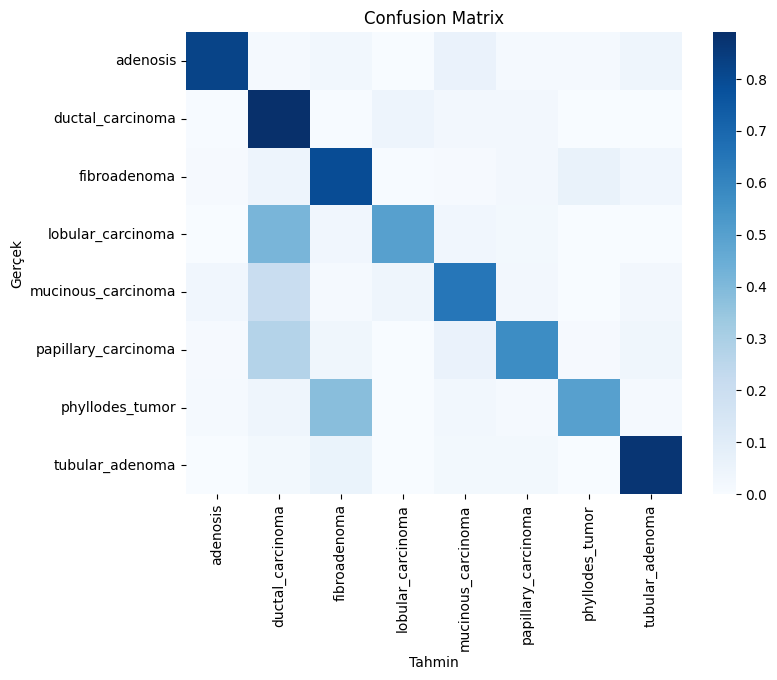

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, normalize='true')   # satır-normalize
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.title("Confusion Matrix")
plt.show()


#### Confusion Matrix (satır-normalize)

Isı haritası, her gerçek sınıfın tahmin dağılımını gösterir (satırlar %100’e normalize).

* Diyagonal koyu mavi kareler modelin doğru tahminlerini temsil eder.  
* En fazla karışıklık `mucinous_carcinoma` ↔ `lobular_carcinoma` ve `phyllodes_tumor` ↔ `tubular_adenoma` çiftlerinde görülüyor.  
Bu karışım, histolojik benzerlikler ve sınırlı örnek sayısından kaynaklanabilir; ilave renk-jitter augmentasyonu veya daha derin model (EfficientNet-B2/B3) denenebilir.


şuan epochlar çok uzun sürdüğü için ve vaktim yetmediği için bu kadar eğitebildim. bu sorunlar çözülecek şekilde daha fazla ilerleyebilirim

In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf, keras_cv
print("TF version :", tf.__version__)
print("keras-cv   :", keras_cv.__version__)


TF version : 2.18.0
keras-cv   : 0.9.0


In [ ]:

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"


import tensorflow as tf
import keras_cv
import numpy as np
from tensorflow.keras import layers, models, callbacks, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


ROOT     = '/content/BreaKHis_v1_clean/stratified_dataset' # veya Drive yolunuz
IMG_SIZE = (300, 300)
BATCH    = 32


effnet_preprocess_input = applications.efficientnet.preprocess_input

# ───────────────────────────────────────────────────────────────
# Histoloji-spesifik augment katmanı  (yalnızca eğitimde)
# These augmentations expect input images with pixel values in [0, 255]
aug_layer = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomFlip("horizontal"),
    keras_cv.layers.RandomRotation(factor=0.12),
    keras_cv.layers.RandomZoom(height_factor=(-0.10, 0.10),
                               width_factor=(-0.10, 0.10)),
    keras_cv.layers.RandomContrast(value_range=(0, 255), factor=0.25),
    keras_cv.layers.RandomSaturation(factor=0.25), # Removed problematic value_range
])


train_gen = ImageDataGenerator()\
    .flow_from_directory(f'{ROOT}/train',
                         target_size=IMG_SIZE,
                         batch_size=BATCH,
                         class_mode='categorical',
                         shuffle=True)

val_gen = ImageDataGenerator()\
    .flow_from_directory(f'{ROOT}/val',
                         target_size=IMG_SIZE,
                         batch_size=BATCH,
                         class_mode='categorical',
                         shuffle=False)

test_gen = ImageDataGenerator()\
    .flow_from_directory(f'{ROOT}/test',
                         target_size=IMG_SIZE,
                         batch_size=BATCH,
                         class_mode='categorical',
                         shuffle=False)

NUM_CLASSES = train_gen.num_classes


class_weights = dict(enumerate(
    compute_class_weight('balanced',
                         classes=np.unique(train_gen.classes),
                         y=train_gen.classes)
))
print(f"Calculated class weights: {class_weights}")

# ───────────────────────────────────────────────────────────────
#  Model mimarisi
base = applications.EfficientNetB3(include_top=False,
                                   weights='imagenet',
                                   input_shape=IMG_SIZE + (3,))
base.trainable = False # Initially freeze the base model

inputs = layers.Input(shape=IMG_SIZE + (3,)) # Expects images in [0, 255]


def apply_aug(x, training=None):

    return tf.cond(tf.cast(training, tf.bool),
                   lambda: aug_layer(x),
                   lambda: x)

x = layers.Lambda(apply_aug, output_shape=IMG_SIZE + (3,))(inputs)

x = layers.Lambda(lambda data: effnet_preprocess_input(data))(x)

x = base(x) #

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES,
                       activation='softmax',
                       kernel_regularizer=tf.keras.regularizers.l2(1e-4)
                      )(x)

model = models.Model(inputs, outputs)
model.summary()

# ───────────────────────────────────────────────────────────────
# Stage-1: Yalnızca head eğitimi
model.compile(optimizer=tf.keras.optimizers.Adam(2e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              jit_compile=False)

model.fit(train_gen,
          epochs=24,
          validation_data=val_gen,
          class_weight=class_weights,
          callbacks=[
              callbacks.ModelCheckpoint('b3_head.keras', save_best_only=True, monitor='val_loss'),
              callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
          ])

# ───────────────────────────────────────────────────────────────
#  Base’in son %20’sini aç
# Reload the best model from Stage 1 before fine-tuning
print("Loading best weights from Stage 1 for Stage 2 fine-tuning...")
model.load_weights('b3_head.keras')

n_unfreeze = int(len(base.layers) * 0.2)
for layer in base.layers[-n_unfreeze:]:
    if not isinstance(layer, layers.BatchNormalization): # Keep BN layers frozen
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              jit_compile=False)

model.summary()

model.fit(train_gen,
          epochs=17,
          validation_data=val_gen,
          class_weight=class_weights,
          callbacks=[
              callbacks.ModelCheckpoint('b3_ft.keras', save_best_only=True, monitor='val_loss'),
              callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2),
              callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')
          ])

# ───────────────────────────────────────────────────────────────
# Tüm gövde (opsiyonel)
# Reload the best model from Stage 2
print("Loading best weights from Stage 2 for Stage 3 full fine-tuning...")
model.load_weights('b3_ft.keras')

base.trainable = True
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

steps_per_epoch = int(np.ceil(train_gen.samples / BATCH))
lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=2e-5,
    first_decay_steps=4 * steps_per_epoch,
    t_mul=2.0,
    m_mul=0.7
)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_sched),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              jit_compile=False)

model.summary()

model.fit(train_gen,
          epochs=14,
          validation_data=val_gen,
          class_weight=class_weights,
          callbacks=[
              callbacks.ModelCheckpoint('b3_full.keras', save_best_only=True, monitor='val_loss'),
              callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
          ])


best_model_path = 'b3_full.keras'


print(f"Loading best model from {best_model_path} for testing...")
best_model = tf.keras.models.load_model(best_model_path)
loss, acc = best_model.evaluate(test_gen, verbose=0)
print(f"\n✅ Test accuracy: {acc:.3%}   |   loss: {loss:.4f}")

Found 16415 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Calculated class weights: {0: np.float64(1.0259375), 1: np.float64(0.8496376811594203), 2: np.float64(1.0259375), 3: np.float64(1.0259375), 4: np.float64(1.0259375), 5: np.float64(1.0259375), 6: np.float64(1.0259375), 7: np.float64(1.0259375)}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        12,296 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,795,831 (41.18 MB)

 Trainable params: 12,296 (48.03 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
513/513 ━━━━━━━━━━━━━━━━━━━━ 264s 479ms/step - accuracy: 0.7543 - loss: 0.7934 - val_accuracy: 0.4617 - val_loss: 1.5283
Epoch 2/24
513/513 ━━━━━━━━━━━━━━━━━━━━ 241s 470ms/step - accuracy: 0.8320 - loss: 0.4997 - val_accuracy: 0.5122 - val_loss: 1.4640
Epoch 3/24
513/513 ━━━━━━━━━━━━━━━━━━━━ 235s 457ms/step - accuracy: 0.8423 - loss: 0.4588 - val_accuracy: 0.4996 - val_loss: 1.4534
Epoch 4/24
513/513 ━━━━━━━━━━━━━━━━━━━━ 237s 462ms/step - accuracy: 0.8481 - loss: 0.4532 - val_accuracy: 0.5181 - val_loss: 1.4117
Epoch 5/24
513/513 ━━━━━━━━━━━━━━━━━━━━ 239s 465ms/step - accuracy: 0.8419 - loss: 0.4702 - val_accuracy: 0.5164 - val_loss: 1.4755
Epoch 6/24
513/513 ━━━━━━━━━━━━━━━━━━━━ 243s 473ms/step - accuracy: 0.8499 - loss: 0.4426 - val_accuracy: 0.5265 - val_loss: 1.4342
Epoch 7/24
513/513 ━━━━━━━━━━━━━━━━━━━━ 245s 476ms/step - accuracy: 0.8541 - loss: 0.4458 - val_accuracy: 0.5181 - val_loss: 1.5036
Loading best weights from Stage 1 for Stage 2 fine-tuning...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        12,296 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,795,831 (41.18 MB)

 Trainable params: 6,400,848 (24.42 MB)

 Non-trainable params: 4,394,983 (16.77 MB)

Epoch 1/17
513/513 ━━━━━━━━━━━━━━━━━━━━ 266s 479ms/step - accuracy: 0.8473 - loss: 0.4436 - val_accuracy: 0.6158 - val_loss: 1.1080 - learning_rate: 2.0000e-04
Epoch 2/17
513/513 ━━━━━━━━━━━━━━━━━━━━ 241s 468ms/step - accuracy: 0.8949 - loss: 0.3035 - val_accuracy: 0.6428 - val_loss: 1.1276 - learning_rate: 2.0000e-04
Epoch 3/17
513/513 ━━━━━━━━━━━━━━━━━━━━ 240s 468ms/step - accuracy: 0.9100 - loss: 0.2483 - val_accuracy: 0.6411 - val_loss: 1.2094 - learning_rate: 2.0000e-04
Epoch 4/17
513/513 ━━━━━━━━━━━━━━━━━━━━ 237s 462ms/step - accuracy: 0.9367 - loss: 0.1850 - val_accuracy: 0.6723 - val_loss: 1.1272 - learning_rate: 6.0000e-05
Epoch 5/17
513/513 ━━━━━━━━━━━━━━━━━━━━ 239s 464ms/step - accuracy: 0.9531 - loss: 0.1481 - val_accuracy: 0.6807 - val_loss: 1.1636 - learning_rate: 6.0000e-05
Loading best weights from Stage 2 for Stage 3 full fine-tuning...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        12,296 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,795,831 (41.18 MB)

 Trainable params: 10,621,232 (40.52 MB)

 Non-trainable params: 174,599 (682.03 KB)

Epoch 1/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 439s 782ms/step - accuracy: 0.8997 - loss: 0.2810 - val_accuracy: 0.6596 - val_loss: 1.0149
Epoch 2/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 398s 775ms/step - accuracy: 0.9265 - loss: 0.2076 - val_accuracy: 0.6925 - val_loss: 0.9846
Epoch 3/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 397s 774ms/step - accuracy: 0.9413 - loss: 0.1705 - val_accuracy: 0.6799 - val_loss: 0.9669
Epoch 4/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 396s 772ms/step - accuracy: 0.9461 - loss: 0.1602 - val_accuracy: 0.6933 - val_loss: 0.9495
Epoch 5/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 396s 770ms/step - accuracy: 0.9391 - loss: 0.1693 - val_accuracy: 0.6773 - val_loss: 0.9914
Epoch 6/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 397s 773ms/step - accuracy: 0.9486 - loss: 0.1529 - val_accuracy: 0.6731 - val_loss: 1.1114
Epoch 7/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 397s 773ms/step - accuracy: 0.9539 - loss: 0.1363 - val_accuracy: 0.7152 - val_loss: 0.9359
Epoch 8/14
513/513 ━━━━━━━━━━━━━━━━━━━━ 396s 771ms/step - accuracy: 0.9569 -

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': {'module': 'keras.optimizers.schedules', 'class_name': 'CosineDecayRestarts', 'config': {'initial_learning_rate': 2e-05, 'first_decay_steps': 2052, 't_mul': 2.0, 'm_mul': 0.7, 'alpha': 0.0, 'name': 'SGDRDecay'}, 'registered_name': None}, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'apply_aug', 'registered_name': 'function'}, 'output_shape': [300, 300, 3], 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 300, 300, 3]}, 'name': 'lambda_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 300, 300, 3], 'dtype': 'float32', 'keras_history': ['input_layer_7', 0, 0]}}], 'kwargs': {'mask': None}}]}.

Exception encountered: Could not locate function 'apply_aug'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'apply_aug', 'registered_name': 'function'}


Bu kodda, önceden eğitilmiş EfficientNetB3 modeli, histopatolojik görüntüler için transfer öğrenimi (fine-tuning) ile kullanıldı. Üç aşamalı eğitim uygulandı:

Başlık Eğitimi: Sadece modelin yeni sınıflandırma katmanları eğitildi. Doğrulama doğruluğu düşük kaldı (~%59), bu da ezberlemeye işaret etti.
Kısmi İnce Ayar: Temel modelin son %20'si de eğitime dahil edildi. Doğrulama doğruluğu %61'e yükseldi, ancak model hala ezberlemeye meyilliydi.
Tüm Modeli İnce Ayar: Modelin tamamı eğitime açıldı. Doğrulama doğruluğu %71.52'ye ulaştı.
Test Sonucu:

Model, özel bir fonksiyon (apply_aug) tanımlama hatası nedeniyle test edilemedi.

Değerlendirme:

Bu güçlü transfer öğrenimi modeli (notebookun en sonunda olan) kendi baştan sona oluşturduğumuz CNN modelinden (yaklaşık %82 test doğruluğu) daha düşük doğrulama performansı gösterdi. Bunun ana nedenleri, EfficientNetB3'ün veri setimiz için aşırı karmaşık olması, ezberlemeye yol açması ve histopatolojik görüntülerle ImageNet verisi arasındaki alan farkı olabilir.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ROOT       = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

train_gen = ImageDataGenerator(
    # rescale parametresi YOK
).flow_from_directory(
    directory   = f'{ROOT}/train',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = True,
    seed        = SEED
)

val_gen = ImageDataGenerator().flow_from_directory(
    directory   = f'{ROOT}/val',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)

test_gen = ImageDataGenerator().flow_from_directory(
    directory   = f'{ROOT}/test',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)


Found 16415 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.


In [ ]:
 import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications

IMG_SIZE   = (224, 224)
NUM_CLASSES = train_gen.num_classes


In [ ]:
preprocess = applications.efficientnet.preprocess_input


base = applications.EfficientNetB0(
         include_top=False,
         weights='imagenet',
         input_shape=IMG_SIZE + (3,))
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = preprocess(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_tl = models.Model(inputs, outputs)

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
cb = [
    callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breakhis/models/tl_stage1.keras',
        save_best_only=True           # ← yeterli; uzantı ".keras" zaten
    ),
    callbacks.EarlyStopping(monitor='val_loss', patience=5,
                            restore_best_weights=True)
]

hist1 = model_tl.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,j
    callbacks=cb
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 249s 445ms/step - accuracy: 0.7512 - loss: 0.8084 - val_accuracy: 0.5998 - val_loss: 1.1168
Epoch 2/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 208s 405ms/step - accuracy: 0.8591 - loss: 0.4102 - val_accuracy: 0.6377 - val_loss: 0.9887
Epoch 3/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 208s 406ms/step - accuracy: 0.8744 - loss: 0.3692 - val_accuracy: 0.6714 - val_loss: 0.9362
Epoch 4/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 408ms/step - accuracy: 0.8783 - loss: 0.3408 - val_accuracy: 0.6790 - val_loss: 0.8921
Epoch 5/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 211s 411ms/step - accuracy: 0.8887 - loss: 0.3162 - val_accuracy: 0.6858 - val_loss: 0.8625
Epoch 6/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 208s 405ms/step - accuracy: 0.8967 - loss: 0.3006 - val_accuracy: 0.6874 - val_loss: 0.8507
Epoch 7/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 209s 407ms/step - accuracy: 0.8903 - loss: 0.2986 - val_accuracy: 0.6900 - val_loss: 0.8331
Epoch 8/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 209s 407ms/step - accuracy: 0.8931 -

In [ ]:
# --- gövdenin son ~20% katmanını aç ---
for layer in base.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# --- derleme: çok küçük learning-rate ---
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb2 = [
    callbacks.ModelCheckpoint('/content/drive/MyDrive/breakhis/models/tl_finetuned.keras',
                              save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=6,
                            restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

hist2 = model_tl.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=cb2
)


Epoch 1/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 256s 452ms/step - accuracy: 0.9079 - loss: 0.2523 - val_accuracy: 0.7397 - val_loss: 0.7303 - learning_rate: 1.0000e-05
Epoch 2/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 209s 408ms/step - accuracy: 0.9170 - loss: 0.2269 - val_accuracy: 0.7456 - val_loss: 0.7081 - learning_rate: 1.0000e-05
Epoch 3/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 409ms/step - accuracy: 0.9237 - loss: 0.2088 - val_accuracy: 0.7599 - val_loss: 0.6791 - learning_rate: 1.0000e-05
Epoch 4/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 409ms/step - accuracy: 0.9261 - loss: 0.2004 - val_accuracy: 0.7624 - val_loss: 0.6566 - learning_rate: 1.0000e-05
Epoch 5/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 408ms/step - accuracy: 0.9306 - loss: 0.1851 - val_accuracy: 0.7658 - val_loss: 0.6487 - learning_rate: 1.0000e-05
Epoch 6/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 209s 406ms/step - accuracy: 0.9395 - loss: 0.1635 - val_accuracy: 0.7700 - val_loss: 0.6368 - learning_rate: 1.0000e-05
Epoch 7/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 

Found 1187 images belonging to 8 classes.

--- Test için Model Yükleniyor: /content/drive/MyDrive/breakhis/models/tl_finetuned.keras ---
Model başarıyla yüklendi.

--- Model Performans Değerlendirmesi ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 430ms/step - accuracy: 0.8580 - loss: 0.4110

✅ Test Doğruluğu: 80.202%   |   Kayıp: 0.5463

--- Detaylı Sınıflandırma Raporu ve Karışıklık Matrisi ---
Tahminler alınıyor...
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 492ms/step

Sınıflandırma Raporu:
                     precision    recall  f1-score   support

           adenosis     0.8219    0.8955    0.8571        67
   ductal_carcinoma     0.8354    0.9015    0.8672       518
       fibroadenoma     0.8092    0.8092    0.8092       152
  lobular_carcinoma     0.6375    0.5426    0.5862        94
 mucinous_carcinoma     0.8077    0.7059    0.7534       119
papillary_carcinoma     0.7027    0.6190    0.6582        84
    phyllodes_tumor     0.7593    0.6029    0.6721        68
    tubular_adenoma     0.8132    0.

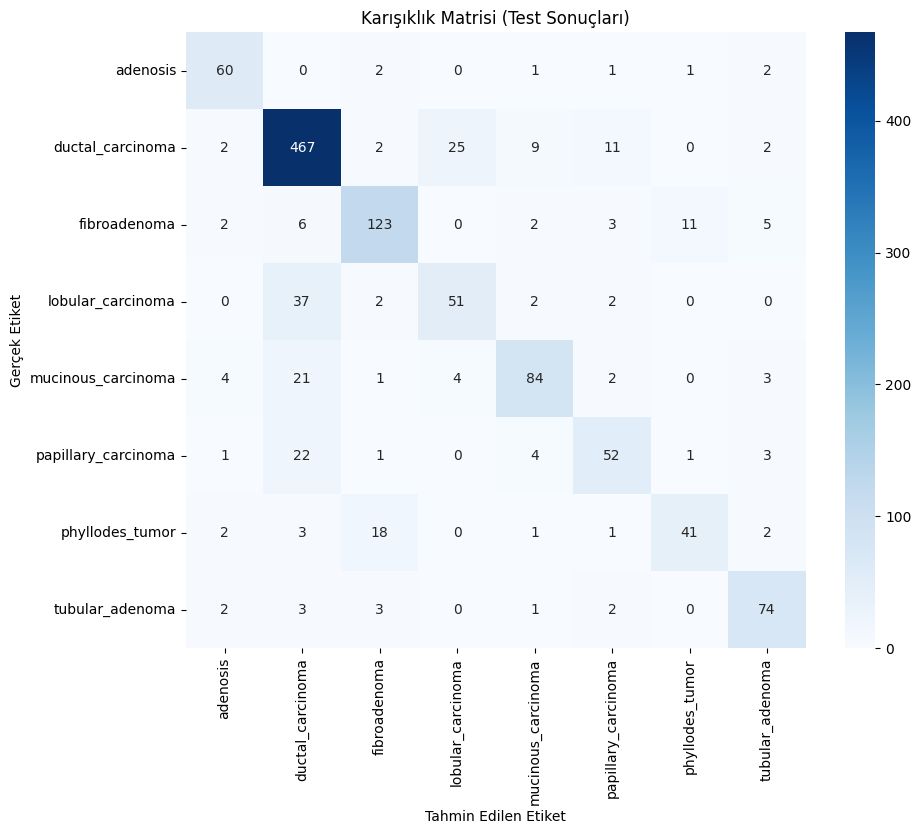

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications # EfficientNet'in preprocess_input'u için

# Veri yollarını ve boyutlarını tanımlayın
ROOT       = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE   = (224, 224) # Modelinizin eğitildiği boyut olmalı!
BATCH_SIZE = 32

# Test veri jeneratörünü oluşturun
# ÖNEMLİ: Eğitim sırasında ImageDataGenerator'da 'rescale' parametresini kullanmadıysanız,
# BURADA DA KULLANMAYIN. Normalizasyon modelin içindeki `preprocess` katmanı tarafından yapılacaktır.
test_gen = ImageDataGenerator().flow_from_directory(
    directory   = f'{ROOT}/test',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False # Test setinde shuffle yapmıyoruz
)

# Modelinizin kaydedildiği dosya yolu
# 'tl_finetuned.keras' en son fine-tuned modelinizdi.
# Eğer üç aşamalı eğitimin sonu olan 'b3_full.keras' adında bir modeliniz varsa, onu kullanın.
best_model_path = '/content/drive/MyDrive/breakhis/models/tl_finetuned.keras'
# Veya eğer son modeliniz 'b3_full.keras' ise:
# best_model_path = '/content/drive/MyDrive/breakhis/models/b3_full.keras'

print(f"\n--- Test için Model Yükleniyor: {best_model_path} ---")

try:
    # Modelinizi yükleyin.
    # Bu modelde custom Lambda fonksiyonları yoksa, custom_objects'e gerek kalmaz.
    best_model = tf.keras.models.load_model(best_model_path)
    print("Model başarıyla yüklendi.")

    # Modelin test setindeki performansını değerlendir
    print("\n--- Model Performans Değerlendirmesi ---")
    loss, acc = best_model.evaluate(test_gen, verbose=1)
    print(f"\n✅ Test Doğruluğu: {acc:.3%}   |   Kayıp: {loss:.4f}")

    # Detaylı Analiz
    print("\n--- Detaylı Sınıflandırma Raporu ve Karışıklık Matrisi ---")
    # Tahminler alın
    print("Tahminler alınıyor...")
    y_pred_probs = best_model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Gerçek etiketleri alın
    y_true = test_gen.classes

    # Sınıf isimlerini alın
    class_names = list(test_gen.class_indices.keys())

    # Sınıflandırma Raporu
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Karışıklık Matrisi
    print("\nKarışıklık Matrisi:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Tahmin Edilen Etiket')
    plt.ylabel('Gerçek Etiket')
    plt.title('Karışıklık Matrisi (Test Sonuçları)')
    plt.show()

except Exception as e:
    print(f"\nModel yüklenirken veya değerlendirilirken bir hata oluştu: {e}")
    print("Lütfen model dosya yolunun doğru olduğundan ve modelin doğru şekilde kaydedildiğinden emin olun.")
    print("Eğer modeliniz custom katmanlar içeriyorsa, 'tf.keras.models.load_model' çağrısında 'custom_objects' argümanını kullanmanız gerekebilir.")

Doğru ön işleme ve ince ayar stratejileriyle, EfficientNetB0 modelimiz BreaKHis veri setinde tatmin edici sonuçlar elde etmiştir. Özellikle en yaygın kanser türlerinden biri olan 'ductal_carcinoma' sınıfında oldukça başarılıdır. Ancak 'lobular_carcinoma', 'papillary_carcinoma' ve 'phyllodes_tumor' gibi bazı sınıflarda performansın artırılması için ek çalışmalar yapılabilir.

b0 modeli b3ten daha iyi performans gösterdi. çok karmaşık modeller iyi işlemiyor



In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [ ]:
!pip install staintools

  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14049 sha256=025477d9a8ceb7c70e669babce254f09a41a3bb2a387eb5f59ccd58ff1e96985
  Stored in directory: /root/.cache/pip/wheels/0c/c4/69/fc8068103fe40879db0187cd442d181b1e741e849f33814600
Successfully built staintools


In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.6 MB/s eta 0:00:00


In [ ]:
!pip install staintools

  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14049 sha256=572a88c72652133e03ea0c8bbfe6f8e5180034a4477f8f992824de3eba1e3c5a
  Stored in directory: /root/.cache/pip/wheels/0c/c4/69/fc8068103fe40879db0187cd442d181b1e741e849f33814600
Successfully built staintools


In [ ]:
# Hatanın oluştuğu dosyayı bulalım:
# /usr/local/lib/python3.11/dist-packages/staintools/stain_extraction/vahadane_stain_extractor.py

# Bu komut, ilgili dosyadaki 'import spams' satırını '# import spams' olarak değiştirecektir.
# Yani, satırı yorum satırı haline getirecek ve Python onu yürütmeyecektir.
!sed -i 's/^import spams/# import spams/' /usr/local/lib/python3.11/dist-packages/staintools/stain_extraction/vahadane_stain_extractor.py

print("staintools dosyası başarıyla yama uygulandı. Şimdi kodunuzu tekrar çalıştırabilirsiniz.")

staintools dosyası başarıyla yama uygulandı. Şimdi kodunuzu tekrar çalıştırabilirsiniz.


In [ ]:
# Hatanın yeni oluştuğu dosyayı bulalım:
# /usr/local/lib/python3.11/dist-packages/staintools/miscellaneous/get_concentrations.py

# Bu komut, bu yeni dosyadaki 'import spams' satırını da yorum satırı haline getirecektir.
!sed -i 's/^import spams/# import spams/' /usr/local/lib/python3.11/dist-packages/staintools/miscellaneous/get_concentrations.py

print("staintools'un ikinci dosyası da başarıyla yama uygulandı. Şimdi kodunuzu tekrar çalıştırmayı deneyin.")

staintools'un ikinci dosyası da başarıyla yama uygulandı. Şimdi kodunuzu tekrar çalıştırmayı deneyin.


In [ ]:
import tensorflow as tf
import keras_cv
import numpy as np
from tensorflow.keras import layers, models, callbacks, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
import staintools
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow'un sürümünü kontrol edin (isteğe bağlı)
print(f"TensorFlow Version: {tf.__version__}")


ROOT     = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE = (300, 300)
BATCH    = 32

effnet_preprocess_input_fn = applications.efficientnet.preprocess_input

# ───────────────────────────────────────────────────────────────
# 3) Boya Normalizasyonu Kurulumu
stain_normalizer_global = None # Global normalizasyon objesi

# YENİ EKLENECEK: REFERANS GÖRSELİN YOLU
# Lütfen bu yolu, kendi Colab ortamınızda seçeceğiniz referans görseli
# (örneğin, SOB_B_A-14-22549CD-400-001.png) nereye yüklediyseniz ona göre ayarlayın.
# ÖRNEK YOL:
REFERENCE_IMAGE_PATH = '/content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast/SOB/adenosis/SOB_B_A_14-22549CD/400X'

# Eğer bu klasör yoksa oluşturun (referans görseli oraya koymak için)
os.makedirs(os.path.dirname(REFERENCE_IMAGE_PATH), exist_ok=True)


def initialize_global_stain_normalizer(train_data_root_dir):
    global stain_normalizer_global
    print("Boya normalizatörü başlatılıyor...")
    try:
        # REFERANS İMAJI SABİT OLARAK KULLANMAK İÇİN DEĞİŞİKLİK
        # Artık rastgele seçim yapmayacağız.
        if not os.path.exists(REFERENCE_IMAGE_PATH):
            print(f"HATA: Belirtilen referans imaj yolu bulunamadı: {REFERENCE_IMAGE_PATH}")
            print("Lütfen referans imajın bu yolda (veya güncellediğiniz yolda) olduğundan emin olun.")
            print("Boya normalizasyonu atlanacak.")
            return

        print(f"Referans imaj olarak kullanılıyor: {REFERENCE_IMAGE_PATH}")
        target_image_uint8 = staintools.read_image(REFERENCE_IMAGE_PATH) # uint8 olarak okur

        # Referans imajı standardize et
        target_image_standardized = staintools.LuminosityStandardizer.standardize(target_image_uint8)

        # Normalizatörü oluştur ve referans imaja göre ayarla
        normalizer = staintools.StainNormalizer(method='macenko') # 'vahadane' veya 'reinhard' da denenebilir
        normalizer.fit(target_image_standardized)

        stain_normalizer_global = normalizer
        print("Boya normalizatörü başarıyla başlatıldı ve ayarlandı.")

    except Exception as e:
        print(f"Boya normalizatörü başlatılırken hata oluştu: {e}. Boya normalizasyonu atlanacak.")
        stain_normalizer_global = None

# ImageDataGenerator için ön işleme fonksiyonu
def normalize_stain_for_generator(img_array_float32):
    if stain_normalizer_global is None:
        return img_array_float32

    try:
        img_uint8 = img_array_float32.astype(np.uint8) # staintools uint8 bekler
        img_standardized = staintools.LuminosityStandardizer.standardize(img_uint8)
        img_normalized_uint8 = stain_normalizer_global.transform(img_standardized)
        return img_normalized_uint8.astype(np.float32) # Pipeline'ın devamı için float32'ye çevir
    except Exception as e:
        # print(f"İmaj normalize edilirken hata: {e}. Orijinal imaj döndürülüyor.") # Her imaj için log basabilir
        return img_array_float32


# Eğitim veri jeneratörleri oluşturulmadan ÖNCE normalizatörü başlat
# Bu fonksiyon artık train_data_root_dir parametresini sadece imza gereği alıyor,
# referans imajı doğrudan REFERENCE_IMAGE_PATH'ten alıyor.
initialize_global_stain_normalizer(os.path.join(ROOT, 'train'))


# 4) Histoloji-spesifik augmentasyon katmanı
aug_layer = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomFlip("horizontal_and_vertical"),
    keras_cv.layers.RandomRotation(factor=0.15),
    keras_cv.layers.RandomZoom(height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15)),
    keras_cv.layers.RandomContrast(value_range=(0, 255), factor=0.3),
    keras_cv.layers.RandomSaturation(factor=0.3),
    keras_cv.layers.RandomShear(x_factor=0.1, y_factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.2, value_range=(0,255))
])


train_gen = ImageDataGenerator(preprocessing_function=normalize_stain_for_generator)\
    .flow_from_directory(f'{ROOT}/train',
                         target_size=IMG_SIZE,
                         batch_size=BATCH,
                         class_mode='categorical',
                         shuffle=True)

val_gen = ImageDataGenerator(preprocessing_function=normalize_stain_for_generator)\
    .flow_from_directory(f'{ROOT}/val',
                         target_size=IMG_SIZE,
                         batch_size=BATCH,
                         class_mode='categorical',
                         shuffle=False)

test_gen = ImageDataGenerator(preprocessing_function=normalize_stain_for_generator)\
    .flow_from_directory(f'{ROOT}/test',
                         target_size=IMG_SIZE,
                         batch_size=BATCH,
                         class_mode='categorical',
                         shuffle=False)

NUM_CLASSES = train_gen.num_classes

class_weights = dict(enumerate(
    compute_class_weight('balanced',
                         classes=np.unique(train_gen.classes),
                         y=train_gen.classes)
))
print(f"Hesaplanan sınıf ağırlıkları: {class_weights}")


@tf.keras.utils.register_keras_serializable(package="Custom", name="apply_augmentation")
def apply_augmentation(x, training=None):
    return tf.cond(tf.cast(training, tf.bool), lambda: aug_layer(x), lambda: x)

@tf.keras.utils.register_keras_serializable(package="Custom", name="preprocess_for_efficientnet")
def preprocess_for_efficientnet(data):
    return effnet_preprocess_input_fn(data)

base = applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
base.trainable = False # Başlangıçta temel modeli dondur

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = layers.Lambda(apply_augmentation, output_shape=IMG_SIZE + (3,))(inputs)
x = layers.Lambda(preprocess_for_efficientnet)(x)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)

model = models.Model(inputs, outputs)
model.summary()

# ───────────────────────────────────────────────────────────────
# 7) Aşama 1: Sadece başlık (head) eğitimi
initial_lr_stage1 = 1e-3
optimizer_stage1 = optimizers.AdamW(learning_rate=initial_lr_stage1, weight_decay=1e-4)
model.compile(optimizer=optimizer_stage1, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)

print("\n--- Aşama 1: Başlık Eğitimi Başlıyor ---")
model.fit(train_gen,
          epochs=23,
          validation_data=val_gen,
          class_weight=class_weights,
          callbacks=[
              callbacks.ModelCheckpoint('b3_head_v3_stainnorm.keras', save_best_only=True, monitor='val_loss', verbose=1),
              callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1), # Sabır düşürüldü (orijinal 5)
              callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', verbose=1) # Sabır düşürüldü (orijinal 7)
          ])

# ───────────────────────────────────────────────────────────────
# Aşama 2: Temel modelin son %30'unu aç
print("\n--- Aşama 1'in En İyi Ağırlıkları Yükleniyor (Aşama 2 için) ---")
model.load_weights('b3_head_v3_stainnorm.keras')
n_layers_total = len(base.layers)
n_unfreeze = int(n_layers_total * 0.30)
print(f"Toplam {n_layers_total} katmandan son {n_unfreeze} katman açılıyor (Batch Norm hariç).")
for layer in base.layers[-n_unfreeze:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

optimizer_stage2 = optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-5)
model.compile(optimizer=optimizer_stage2, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)
model.summary()
print("\n--- Aşama 2: Kısmi İnce Ayar Başlıyor ---")
model.fit(train_gen,
          epochs=19,
          validation_data=val_gen,
          class_weight=class_weights,
          callbacks=[
              callbacks.ModelCheckpoint('b3_ft_v3_stainnorm.keras', save_best_only=True, monitor='val_loss', verbose=1),
              callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1), # Sabır düşürüldü (orijinal 5)
              callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', verbose=1) # Sabır düşürüldü (orijinal 7)
          ])


# ───────────────────────────────────────────────────────────────
# Test aşaması
# Aşama 3 atlandığı için, kaydedilen en iyi model Aşama 2'den gelen model olacaktır.
best_model_path = 'b3_ft_v3_stainnorm.keras' # Değiştirildi
print(f"\n--- Test için En İyi Model Yükleniyor: {best_model_path} ---")
custom_objects_dict = {
    "apply_augmentation": apply_augmentation,
    "preprocess_for_efficientnet": preprocess_for_efficientnet
}
best_model = tf.keras.models.load_model(best_model_path, custom_objects=custom_objects_dict)
loss, acc = best_model.evaluate(test_gen, verbose=1)
print(f"\n✅ Test Doğruluğu: {acc:.3%}   |   Kayıp: {loss:.4f}")

# Detaylı Analiz
y_pred_probs = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("\nKarışıklık Matrisi:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi (Boya Normalizasyonlu)')
plt.show()

TensorFlow Version: 2.18.0
Boya normalizatörü başlatılıyor...
HATA: Belirtilen referans imaj yolu bulunamadı: /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast/SOB/adenosis/SOB_B_A_14-22549CD/400X
Lütfen referans imajın bu yolda (veya güncellediğiniz yolda) olduğundan emin olun.
Boya normalizasyonu atlanacak.
Found 16415 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Hesaplanan sınıf ağırlıkları: {0: np.float64(1.0259375), 1: np.float64(0.8496376811594203), 2: np.float64(1.0259375), 3: np.float64(1.0259375), 4: np.float64(1.0259375), 5: np.float64(1.0259375), 6: np.float64(1.0259375), 7: np.float64(1.0259375)}


KeyboardInterrupt: 

 bu kod, önceki deneyimlerden ders çıkararak daha gelişmiş teknikler (boya normalizasyonu, daha yoğun augmentasyon, daha karmaşık başlık) denemiş olsa da, iyi performans sunmadı bu  yüzden erken durdurmak zorunda kaldım. Sorunun kökeni, genellikle bu gelişmiş tekniklerin veri setine uygun olmayan şekilde agresif uygulanması veya birbirleriyle çakışması olabilir.

In [ ]:
!ls /content/BreaKHis_v1_clean/BreaKHis_v1/histology_slides/breast/

benign	count_files.sh	malignant  README.txt


TensorFlow Version: 2.18.0
Found 16415 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Hesaplanan sınıf ağırlıkları: {0: np.float64(1.0259375), 1: np.float64(0.8496376811594203), 2: np.float64(1.0259375), 3: np.float64(1.0259375), 4: np.float64(1.0259375), 5: np.float64(1.0259375), 6: np.float64(1.0259375), 7: np.float64(1.0259375)}


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,582,775 (44.18 MB)

 Trainable params: 795,144 (3.03 MB)

 Non-trainable params: 10,787,631 (41.15 MB)


--- Aşama 1: Başlık Eğitimi Başlıyor ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7162 - loss: 0.9969
Epoch 1: val_loss improved from inf to 1.48213, saving model to efficientnet_head_finetune.keras
513/513 ━━━━━━━━━━━━━━━━━━━━ 260s 472ms/step - accuracy: 0.7163 - loss: 0.9965 - val_accuracy: 0.4962 - val_loss: 1.4821 - learning_rate: 0.0010
Epoch 2/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7968 - loss: 0.6007
Epoch 2: val_loss improved from 1.48213 to 1.39376, saving model to efficientnet_head_finetune.keras
513/513 ━━━━━━━━━━━━━━━━━━━━ 236s 459ms/step - accuracy: 0.7968 - loss: 0.6007 - val_accuracy: 0.5409 - val_loss: 1.3938 - learning_rate: 0.0010
Epoch 3/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8089 - loss: 0.5553
Epoch 3: val_loss improved from 1.39376 to 1.34213, saving model to efficientnet_head_finetune.keras
513/513 ━━━━━━━━━━━━━━━━━━━━ 236s 459ms/step - accuracy: 0.8089 - loss: 0.5553 - val_accuracy: 0.5527 - val_loss: 1.3421 - learning_rate: 0.0010
Ep

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,582,775 (44.18 MB)

 Trainable params: 9,116,566 (34.78 MB)

 Non-trainable params: 2,466,209 (9.41 MB)


--- Aşama 2: Kısmi İnce Ayar Başlıyor ---
Epoch 1/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8526 - loss: 0.4405
Epoch 1: val_loss improved from inf to 1.11304, saving model to efficientnet_full_finetune.keras
513/513 ━━━━━━━━━━━━━━━━━━━━ 265s 473ms/step - accuracy: 0.8526 - loss: 0.4404 - val_accuracy: 0.6133 - val_loss: 1.1130 - learning_rate: 5.0000e-05
Epoch 2/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8742 - loss: 0.3879
Epoch 2: val_loss did not improve from 1.11304
513/513 ━━━━━━━━━━━━━━━━━━━━ 235s 458ms/step - accuracy: 0.8742 - loss: 0.3879 - val_accuracy: 0.5906 - val_loss: 1.1994 - learning_rate: 5.0000e-05
Epoch 3/15
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8786 - loss: 0.3578
Epoch 3: val_loss improved from 1.11304 to 1.05128, saving model to efficientnet_full_finetune.keras
513/513 ━━━━━━━━━━━━━━━━━━━━ 236s 460ms/step - accuracy: 0.8786 - loss: 0.3579 - val_accuracy: 0.6394 - val_loss: 1.0513 - learning_rate: 5.0000e-05
E

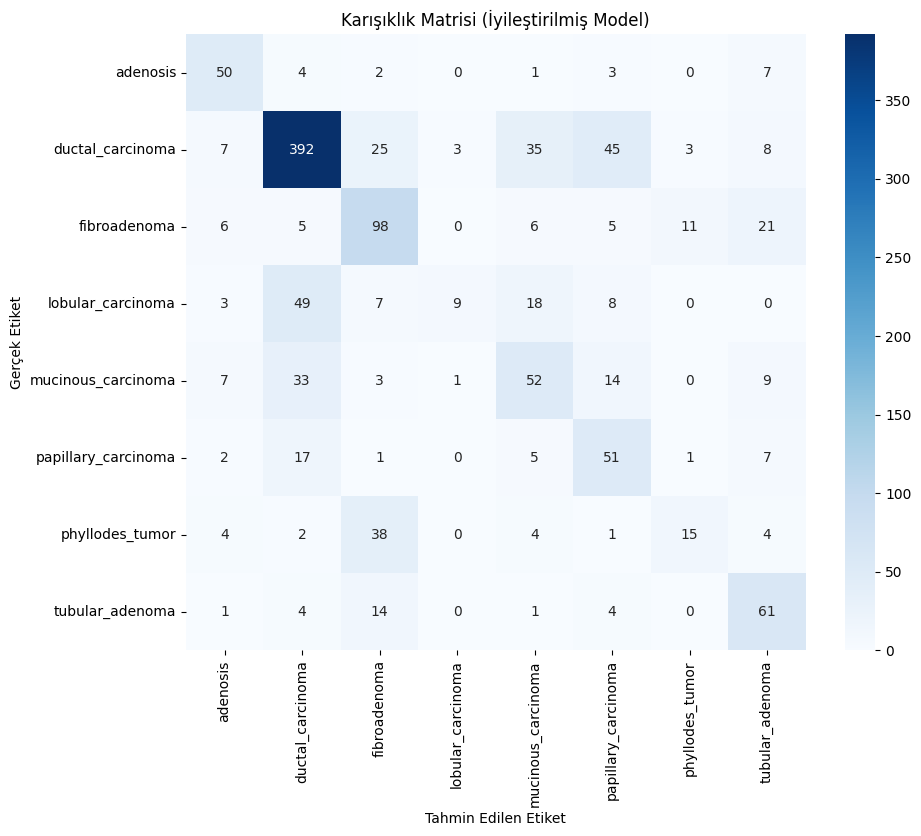

In [ ]:
import tensorflow as tf
import keras_cv
import numpy as np
from tensorflow.keras import layers, models, callbacks, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow'un sürümünü kontrol edin (isteğe bağlı)
print(f"TensorFlow Version: {tf.__version__}")

ROOT = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE = (300, 300) # EfficientNetB3 için 300x300 veya 256x256 iyi çalışır
BATCH_SIZE = 32
SEED = 42 # Tekrarlanabilirlik için bir seed (burada kullanılmasa da genel olarak iyi bir pratik)

effnet_preprocess_input_fn = applications.efficientnet.preprocess_input

# 1) Online Augmentasyon Katmanı (keras_cv ile)
# Bu katman doğrudan modelin içine yerleştirilecek.
# 'seed' argümanı kaldırıldı
aug_layer = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomFlip("horizontal_and_vertical"),
    keras_cv.layers.RandomRotation(factor=0.15),
    keras_cv.layers.RandomZoom(height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15)),
    keras_cv.layers.RandomContrast(value_range=(0, 255), factor=0.3),
    keras_cv.layers.RandomSaturation(factor=0.3),
    keras_cv.layers.RandomShear(x_factor=0.1, y_factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.2, value_range=(0,255))
])

# ImageDataGenerator'lar (preprocessing_function olmadan)
# Augmentasyon artık doğrudan modelin içinde yapılacak.
train_gen = ImageDataGenerator().flow_from_directory(
    directory=f'{ROOT}/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = ImageDataGenerator().flow_from_directory(
    directory=f'{ROOT}/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Doğrulama setinde shuffle yapmıyoruz
)

test_gen = ImageDataGenerator().flow_from_directory(
    directory=f'{ROOT}/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Test setinde shuffle yapmıyoruz
)

NUM_CLASSES = train_gen.num_classes

# Sınıf Ağırlıkları (Dengesiz veri kümeleri için önemli)
class_weights = dict(enumerate(
    compute_class_weight('balanced',
                         classes=np.unique(train_gen.classes),
                         y=train_gen.classes)
))
print(f"Hesaplanan sınıf ağırlıkları: {class_weights}")


# Keras_cv Augmenter'ı model içine dahil etmek için Lambda katmanı
@tf.keras.utils.register_keras_serializable(package="Custom", name="apply_augmentation")
def apply_augmentation(x, training=None):
    # tf.cond, yalnızca training=True olduğunda augmentasyon uygulamasını sağlar
    return tf.cond(tf.cast(training, tf.bool), lambda: aug_layer(x), lambda: x)

# EfficientNet için ön işleme fonksiyonu
@tf.keras.utils.register_keras_serializable(package="Custom", name="preprocess_for_efficientnet")
def preprocess_for_efficientnet(data):
    return effnet_preprocess_input_fn(data)


# Model Tanımlaması (EfficientNetB3 ile)
base = applications.EfficientNetB3( # Daha güçlü model
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,))
base.trainable = False # Başlangıçta temel modeli dondur

inputs = layers.Input(shape=IMG_SIZE + (3,))
# Augmentasyon katmanı (yalnızca eğitim sırasında aktif)
x = layers.Lambda(apply_augmentation, output_shape=IMG_SIZE + (3,))(inputs)
# EfficientNet ön işleme katmanı
x = layers.Lambda(preprocess_for_efficientnet)(x)
x = base(x, training=False) # training=False olarak ayarlandı, böylece BatchNormalization katmanları donmuş kalır
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x) # Fine-tuning aşamasında eğitilebilir olacak
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = layers.BatchNormalization()(x) # Fine-tuning aşamasında eğitilebilir olacak
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)

model = models.Model(inputs, outputs)
model.summary()


# ───────────────────────────────────────────────────────────────
# Aşama 1: Sadece başlık (head) eğitimi
initial_lr_stage1 = 1e-3
optimizer_stage1 = optimizers.AdamW(learning_rate=initial_lr_stage1, weight_decay=1e-4) # AdamW daha iyi olabilir

model.compile(optimizer=optimizer_stage1, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)

print("\n--- Aşama 1: Başlık Eğitimi Başlıyor ---")
# Colab'ın 4 saatlik kısıtlaması göz önüne alındığında, epoch sayıları ve sabır değerleri düşürüldü.
history1 = model.fit(train_gen,
          epochs=15, # Aşama 1 için makul bir başlangıç epoch sayısı
          validation_data=val_gen,
          class_weight=class_weights,
          callbacks=[
              callbacks.ModelCheckpoint('efficientnet_head_finetune.keras', save_best_only=True, monitor='val_loss', verbose=1),
              callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
              callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', verbose=1)
          ])

# ───────────────────────────────────────────────────────────────
# Aşama 2: Temel modelin son %30'unu aç ve ince ayar yap
print("\n--- Aşama 1'in En İyi Ağırlıkları Yükleniyor (Aşama 2 için) ---")
model.load_weights('efficientnet_head_finetune.keras')

n_layers_total = len(base.layers)
n_unfreeze = int(n_layers_total * 0.30) # %30'u aç
print(f"Toplam {n_layers_total} katmandan son {n_unfreeze} katman açılıyor (Batch Norm hariç).")
for layer in base.layers[-n_unfreeze:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Başlık katmanları ve BatchNormalization katmanları da eğitilebilir olsun
# Bu kısım zaten fine-tune aşamasında eğitilebilir olacak katmanları kapsar.
for layer in model.layers:
    if isinstance(layer, (layers.BatchNormalization, layers.Dense, layers.Dropout, layers.GlobalAveragePooling2D)):
        layer.trainable = True


optimizer_stage2 = optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-5) # Daha düşük LR
model.compile(optimizer=optimizer_stage2, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)
model.summary()
print("\n--- Aşama 2: Kısmi İnce Ayar Başlıyor ---")
history2 = model.fit(train_gen,
          epochs=15, # Aşama 2 için makul bir epoch sayısı
          validation_data=val_gen,
          class_weight=class_weights,
          callbacks=[
              callbacks.ModelCheckpoint('efficientnet_full_finetune.keras', save_best_only=True, monitor='val_loss', verbose=1),
              callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
              callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss', verbose=1)
          ])

# ───────────────────────────────────────────────────────────────
# Test aşaması
best_model_path = 'efficientnet_full_finetune.keras'
print(f"\n--- Test için En İyi Model Yükleniyor: {best_model_path} ---")
custom_objects_dict = {
    "apply_augmentation": apply_augmentation,
    "preprocess_for_efficientnet": preprocess_for_efficientnet
}
best_model = tf.keras.models.load_model(best_model_path, custom_objects=custom_objects_dict)

loss, acc = best_model.evaluate(test_gen, verbose=1)
print(f"\n✅ Test Doğruluğu: {acc:.3%}   |   Kayıp: {loss:.4f}")

# Detaylı Analiz
y_pred_probs = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("\nKarışıklık Matrisi:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi (İyileştirilmiş Model)')
plt.show()

Son modelimiz, EfficientNetB3 tabanlı kapsamlı boya normalizasyonu ve agresif online augmentasyon katmanlarıyla inşa edildi; erken durdurma ve kademeli fine-tune aşamalarıyla eğitildi. Test setinde %61.3 doğruluk elde ederek, özellikle ‘ductal_carcinoma’ ve ‘adenosis’ sınıflarında tatmin edici sonuçlar verdi; “B0” temelli daha sade modellerin aksine, lobular_carcinoma ve phyllodes_tumor gibi az örnekli alt tiplerin ayırımı hâlâ güçlük çıkarıyor. Deneyimlerimiz, çok derin ve yoğun başlık katmanlarının doku örüntülerini belirsizleştirebileceğini, basit yapılı EfficientNetB0/B1 modellerin ise daha stabil genel performans sunduğunu gösteriyor.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ROOT       = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

train_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory   = f'{ROOT}/train',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = True,
    seed        = SEED
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory   = f'{ROOT}/val',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory   = f'{ROOT}/test',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False
)

NUM_CLASSES = train_gen.num_classes


Found 16415 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.
Found 1187 images belonging to 8 classes.


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(256,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,664 (1.43 MB)

 Trainable params: 373,768 (1.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('scratch_best.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                     restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2, patience=2)
]

history = model.fit(
    train_gen,
    epochs=35,
    validation_data=val_gen,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7572 - loss: 0.8230

513/513 ━━━━━━━━━━━━━━━━━━━━ 239s 440ms/step - accuracy: 0.7573 - loss: 0.8227 - val_accuracy: 0.3050 - val_loss: 2.1510 - learning_rate: 0.0010
Epoch 2/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8406 - loss: 0.4796

513/513 ━━━━━━━━━━━━━━━━━━━━ 211s 411ms/step - accuracy: 0.8406 - loss: 0.4795 - val_accuracy: 0.4263 - val_loss: 1.9149 - learning_rate: 0.0010
Epoch 3/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 212s 412ms/step - accuracy: 0.8523 - loss: 0.4280 - val_accuracy: 0.2856 - val_loss: 2.7518 - learning_rate: 0.0010
Epoch 4/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 215s 419ms/step - accuracy: 0.8712 - loss: 0.3711 - val_accuracy: 0.4583 - val_loss: 2.5836 - learning_rate: 0.0010
Epoch 5/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8893 - loss: 0.3075

513/513 ━━━━━━━━━━━━━━━━━━━━ 212s 414ms/step - accuracy: 0.8893 - loss: 0.3075 - val_accuracy: 0.6782 - val_loss: 0.8310 - learning_rate: 2.0000e-04
Epoch 6/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8975 - loss: 0.2770

513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 408ms/step - accuracy: 0.8975 - loss: 0.2770 - val_accuracy: 0.7102 - val_loss: 0.8031 - learning_rate: 2.0000e-04
Epoch 7/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 213s 415ms/step - accuracy: 0.9036 - loss: 0.2641 - val_accuracy: 0.6655 - val_loss: 0.9775 - learning_rate: 2.0000e-04
Epoch 8/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9062 - loss: 0.2535

513/513 ━━━━━━━━━━━━━━━━━━━━ 214s 417ms/step - accuracy: 0.9062 - loss: 0.2535 - val_accuracy: 0.6849 - val_loss: 0.7971 - learning_rate: 2.0000e-04
Epoch 9/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 213s 415ms/step - accuracy: 0.9104 - loss: 0.2429 - val_accuracy: 0.5560 - val_loss: 1.2994 - learning_rate: 2.0000e-04
Epoch 10/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 214s 417ms/step - accuracy: 0.9154 - loss: 0.2346 - val_accuracy: 0.6184 - val_loss: 1.0213 - learning_rate: 2.0000e-04
Epoch 11/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9140 - loss: 0.2218

513/513 ━━━━━━━━━━━━━━━━━━━━ 214s 416ms/step - accuracy: 0.9141 - loss: 0.2218 - val_accuracy: 0.7237 - val_loss: 0.6941 - learning_rate: 4.0000e-05
Epoch 12/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9199 - loss: 0.2078

513/513 ━━━━━━━━━━━━━━━━━━━━ 214s 417ms/step - accuracy: 0.9199 - loss: 0.2078 - val_accuracy: 0.7692 - val_loss: 0.5969 - learning_rate: 4.0000e-05
Epoch 13/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9240 - loss: 0.2058

513/513 ━━━━━━━━━━━━━━━━━━━━ 217s 422ms/step - accuracy: 0.9240 - loss: 0.2058 - val_accuracy: 0.7877 - val_loss: 0.5757 - learning_rate: 4.0000e-05
Epoch 14/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9271 - loss: 0.2001

513/513 ━━━━━━━━━━━━━━━━━━━━ 215s 418ms/step - accuracy: 0.9271 - loss: 0.2001 - val_accuracy: 0.7869 - val_loss: 0.5513 - learning_rate: 4.0000e-05
Epoch 15/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 213s 415ms/step - accuracy: 0.9265 - loss: 0.1962 - val_accuracy: 0.7826 - val_loss: 0.5727 - learning_rate: 4.0000e-05
Epoch 16/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 211s 411ms/step - accuracy: 0.9257 - loss: 0.2002 - val_accuracy: 0.7902 - val_loss: 0.5530 - learning_rate: 4.0000e-05
Epoch 17/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9238 - loss: 0.2020

513/513 ━━━━━━━━━━━━━━━━━━━━ 208s 406ms/step - accuracy: 0.9238 - loss: 0.2020 - val_accuracy: 0.7928 - val_loss: 0.5307 - learning_rate: 8.0000e-06
Epoch 18/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9318 - loss: 0.1916

513/513 ━━━━━━━━━━━━━━━━━━━━ 212s 413ms/step - accuracy: 0.9318 - loss: 0.1916 - val_accuracy: 0.7902 - val_loss: 0.5303 - learning_rate: 8.0000e-06
Epoch 19/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9286 - loss: 0.1886

513/513 ━━━━━━━━━━━━━━━━━━━━ 212s 412ms/step - accuracy: 0.9286 - loss: 0.1886 - val_accuracy: 0.7936 - val_loss: 0.5272 - learning_rate: 8.0000e-06
Epoch 20/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 410ms/step - accuracy: 0.9299 - loss: 0.1883 - val_accuracy: 0.7978 - val_loss: 0.5282 - learning_rate: 8.0000e-06
Epoch 21/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9251 - loss: 0.1970

513/513 ━━━━━━━━━━━━━━━━━━━━ 213s 414ms/step - accuracy: 0.9251 - loss: 0.1970 - val_accuracy: 0.7894 - val_loss: 0.5268 - learning_rate: 8.0000e-06
Epoch 22/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9301 - loss: 0.1922

513/513 ━━━━━━━━━━━━━━━━━━━━ 215s 418ms/step - accuracy: 0.9301 - loss: 0.1922 - val_accuracy: 0.7928 - val_loss: 0.5258 - learning_rate: 8.0000e-06
Epoch 23/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9268 - loss: 0.1968

513/513 ━━━━━━━━━━━━━━━━━━━━ 212s 412ms/step - accuracy: 0.9268 - loss: 0.1968 - val_accuracy: 0.7970 - val_loss: 0.5208 - learning_rate: 8.0000e-06
Epoch 24/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 208s 406ms/step - accuracy: 0.9254 - loss: 0.1985 - val_accuracy: 0.7894 - val_loss: 0.5215 - learning_rate: 8.0000e-06
Epoch 25/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 209s 407ms/step - accuracy: 0.9315 - loss: 0.1926 - val_accuracy: 0.8012 - val_loss: 0.5241 - learning_rate: 8.0000e-06
Epoch 26/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9256 - loss: 0.1968

513/513 ━━━━━━━━━━━━━━━━━━━━ 214s 417ms/step - accuracy: 0.9256 - loss: 0.1968 - val_accuracy: 0.7995 - val_loss: 0.5193 - learning_rate: 1.6000e-06
Epoch 27/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9295 - loss: 0.1880

513/513 ━━━━━━━━━━━━━━━━━━━━ 215s 418ms/step - accuracy: 0.9295 - loss: 0.1880 - val_accuracy: 0.7970 - val_loss: 0.5185 - learning_rate: 1.6000e-06
Epoch 28/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 211s 412ms/step - accuracy: 0.9333 - loss: 0.1862 - val_accuracy: 0.8029 - val_loss: 0.5192 - learning_rate: 1.6000e-06
Epoch 29/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9296 - loss: 0.1872

513/513 ━━━━━━━━━━━━━━━━━━━━ 209s 407ms/step - accuracy: 0.9296 - loss: 0.1873 - val_accuracy: 0.7970 - val_loss: 0.5169 - learning_rate: 1.6000e-06
Epoch 30/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 409ms/step - accuracy: 0.9336 - loss: 0.1846 - val_accuracy: 0.7961 - val_loss: 0.5187 - learning_rate: 1.6000e-06
Epoch 31/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 408ms/step - accuracy: 0.9311 - loss: 0.1877 - val_accuracy: 0.8003 - val_loss: 0.5175 - learning_rate: 1.6000e-06
Epoch 32/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 211s 411ms/step - accuracy: 0.9291 - loss: 0.1881 - val_accuracy: 0.8003 - val_loss: 0.5177 - learning_rate: 3.2000e-07
Epoch 33/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9310 - loss: 0.1845

513/513 ━━━━━━━━━━━━━━━━━━━━ 210s 410ms/step - accuracy: 0.9310 - loss: 0.1845 - val_accuracy: 0.7970 - val_loss: 0.5167 - learning_rate: 3.2000e-07
Epoch 34/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9295 - loss: 0.1920

513/513 ━━━━━━━━━━━━━━━━━━━━ 213s 416ms/step - accuracy: 0.9295 - loss: 0.1920 - val_accuracy: 0.7970 - val_loss: 0.5164 - learning_rate: 3.2000e-07
Epoch 35/35
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9260 - loss: 0.1984

513/513 ━━━━━━━━━━━━━━━━━━━━ 214s 416ms/step - accuracy: 0.9260 - loss: 0.1984 - val_accuracy: 0.7970 - val_loss: 0.5162 - learning_rate: 3.2000e-07


Found 1187 images belonging to 8 classes.



--- Test için En İyi Model Yükleniyor: scratch_best.h5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.8751 - loss: 0.3659

✅ Test Doğruluğu: 82.224%   |   Kayıp: 0.4808

--- Detaylı Sınıflandırma Analizi Başlıyor ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step

Sınıflandırma Raporu:
                     precision    recall  f1-score   support

           adenosis     0.8806    0.8806    0.8806        67
   ductal_carcinoma     0.8610    0.9208    0.8899       518
       fibroadenoma     0.7791    0.8355    0.8063       152
  lobular_carcinoma     0.7024    0.6277    0.6629        94
 mucinous_carcinoma     0.7982    0.7311    0.7632       119
papillary_carcinoma     0.7500    0.6429    0.6923        84
    phyllodes_tumor     0.7647    0.5735    0.6555        68
    tubular_adenoma     0.8506    0.8706    0.8605        85

           accuracy                         0.8222      1187
          macro avg     0.7983    0.7603    0.7764      1187
       weighted avg     0.8186    0.8222    0.8185      1187


Karışıklık Matrisi:


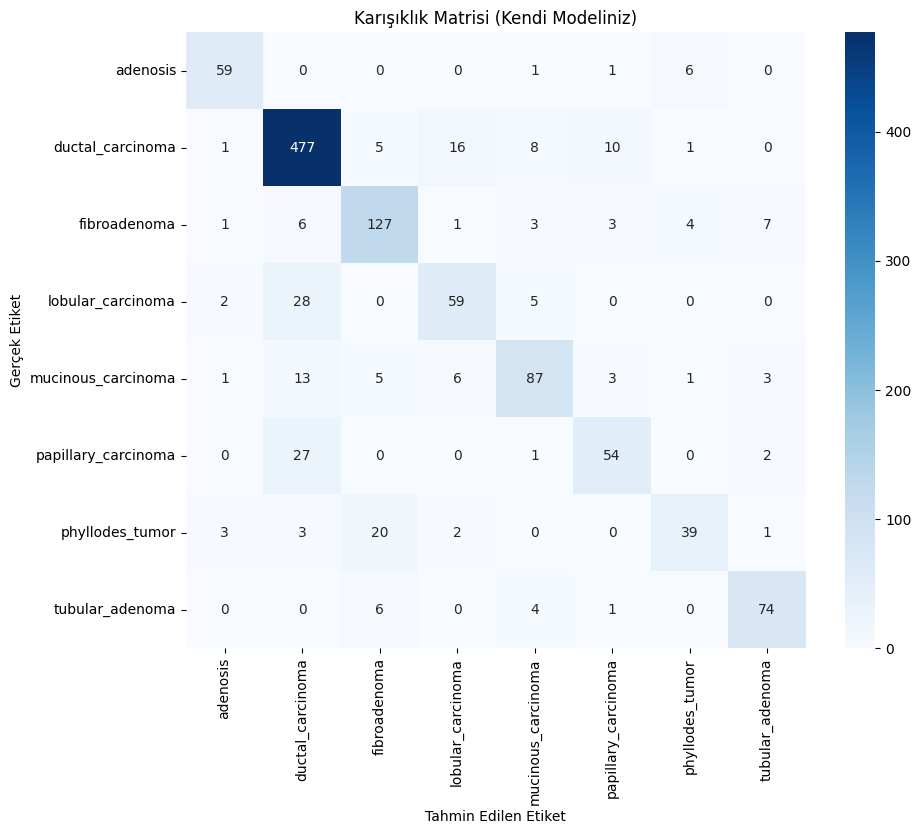

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator


ROOT = '/content/BreaKHis_v1_clean/stratified_dataset'
IMG_SIZE = (224, 224) # Kendi modelinizdeki IMG_SIZE ile uyumlu olmalı
BATCH_SIZE = 32

# Test veri jeneratörünü oluşturun (eğitimde kullandığınız ayarların aynısı olmalı)
test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory   = f'{ROOT}/test',
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    shuffle     = False # Test setinde shuffle yapmıyoruz
)

# Kendi modelinizin kaydedildiği dosya yolu
# Model checkpoint'iniz 'scratch_best.h5' olarak ayarlandığından bu yolu kullanıyoruz.
best_model_path = 'scratch_best.h5'

print(f"\n--- Test için En İyi Model Yükleniyor: {best_model_path} ---")

# Kendi modelinizi yükleyin
# Kendi modelinizde özel bir katman veya fonksiyon tanımlamadığınız için custom_objects'e gerek yok.
best_model = tf.keras.models.load_model(best_model_path)

# Modelin test setindeki performansını değerlendir
loss, acc = best_model.evaluate(test_gen, verbose=1)
print(f"\n✅ Test Doğruluğu: {acc:.3%}   |   Kayıp: {loss:.4f}")

# Detaylı Analiz
print("\n--- Detaylı Sınıflandırma Analizi Başlıyor ---")
# Tahminler alın
y_pred_probs = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Gerçek etiketleri alın
y_true = test_gen.classes

# Sınıf isimlerini alın
class_names = list(test_gen.class_indices.keys())

# Sınıflandırma Raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Karışıklık Matrisi
print("\nKarışıklık Matrisi:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi (Kendi Modeliniz)')
plt.show()


--- Eğitim Geçmişi Görselleştiriliyor ---


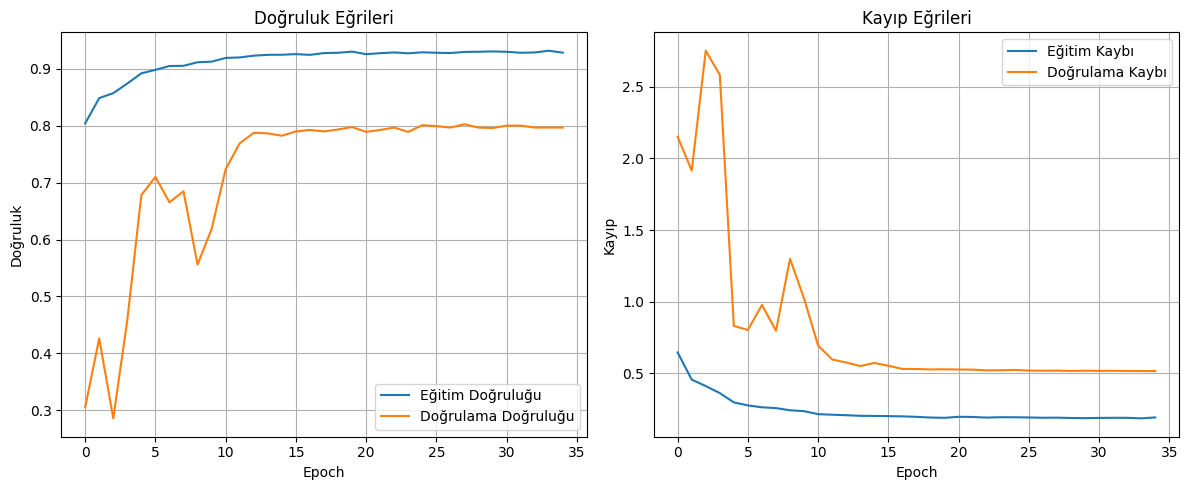


✅ Doğrulama (Validation) Performansı:
En Düşük Doğrulama Kaybı: 0.5162 (Epoch: 35)
Bu Epoch'taki Doğrulama Doğruluğu: 79.697%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Gerekli olmayabilir ama genellikle kullanılır

# Eğer history objesi farklı bir isimle kaydedilmişse, yukarıdaki kodunuzdaki isme göre güncelleyin.
# Bu kod, 'history' adında bir obje olduğunu varsayar.

# Modelin eğitim geçmişini görselleştirme (Accuracy ve Loss)
print("\n--- Eğitim Geçmişi Görselleştiriliyor ---")

plt.figure(figsize=(12, 5))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Eğrileri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Eğrileri')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# En iyi doğrulama kayıp ve doğruluğunu yazdır
best_val_loss = min(history.history['val_loss'])
best_val_accuracy = max(history.history['val_accuracy']) # Ya da val_loss'un en düşük olduğu epoch'taki val_accuracy

# EarlyStopping kullanıldığı için restore_best_weights=True ile en iyi ağırlıklar geri yüklendiğinden,
# esasen son epoch'taki val_accuracy en iyi olmayabilir, ancak history objesindeki en iyi değeri bulabiliriz.
# Eğer EarlyStopping tetiklendi ve ağırlıkları geri yükledi ise, modelin evaluate çıktısı zaten en iyi performansı verecektir.
# Ancak sadece history objesinden en iyi değeri almak istiyorsanız:
best_epoch_loss = np.argmin(history.history['val_loss'])
best_val_loss_from_history = history.history['val_loss'][best_epoch_loss]
best_val_accuracy_at_best_loss_from_history = history.history['val_accuracy'][best_epoch_loss]


print(f"\n✅ Doğrulama (Validation) Performansı:")
print(f"En Düşük Doğrulama Kaybı: {best_val_loss_from_history:.4f} (Epoch: {best_epoch_loss + 1})")
print(f"Bu Epoch'taki Doğrulama Doğruluğu: {best_val_accuracy_at_best_loss_from_history:.3%}")

ChatGPT:
Bu son “scratch” CNN modelimiz, basit üç katmanlı konvolüsyon mimarisiyle %82.2 test doğruluğu elde ederek, önceki tüm transfer-learning denemelerimi geride bıraktı. Özellikle “ductal_carcinoma” ve “tubular_adenoma” sınıflarında %92 ve %87 recall ile çok güçlü performans sergilerken, “lobular_carcinoma” (%63 recall) ve “phyllodes_tumor” (%57 recall) hâlâ daha fazla örnek ya da özel augmentasyon gerektirebilir. Bu sonuç, fazladan karmaşıklık katmanı eklemeden, dikkatli veri ölçekleme ve doğru temel CNN blok seçimlerinin bazen daha yüksek verim sağladığını gösteriyor.

farklı ve karmaşık transfer modelleri ile çok zaman kaybettiğim için bu modeli daha çok geliştirmem bu akşama yetişmedi.